In [1]:
import numpy as np
import pandas as pd
from ase import Atoms
from ase import neighborlist
from ase import units
from ase.io import read, write
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from til_birk.shaved_var import *

plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=20, titlesize=20, labelweight="bold", titleweight="bold")    # x and y axes
plt.rc('xtick', labelsize=20)    # Major Ticks
plt.rc('ytick', labelsize=20)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])

['sans-serif']


In [2]:
pred_step = 4
input = 8
file = r"Data\Model_test\EtOH_moldyn_data.xyz"
#file = r"Data\EtOH_moldyn_for.xyz"

# Function which predicts the forces on the atoms in a molecule for a certain number of time steps
#_____Inputs______
# file - String with the name of the xyz file containing information on the molecule
# input - Positive integer with the number of data points used as input in training the OLS VAR models
# pred_step - Positive integer which decides the number of time steps predicted by the OLS VAR models
# order - Positive integer which decides the numper of points in the past is used to predict the next point
#
#_____Output______
# Returns a 3D np array with the predicted forces. The array as the following shape [N, 3, p], with N being the number of atoms in the molecule
# and p being the number of time steps predicted
def predict_forces(mol, file=file, input=input, pred_step=pred_step, max_lag=2, alpha=0, method="SVD"):
    #mol = read(file, index=slice(0, input))
    #mol = read(file, index=slice(-input, None))
    
    n_atoms = mol[0].get_global_number_of_atoms()
    predicted_forces = np.zeros((n_atoms, 3, pred_step))
    forces = np.zeros((input, 3*n_atoms))

    #Get the forces in correct format for model
    for i in range(input):
        forces[i,:] = mol[i].get_forces().ravel()
    
    #Fit model
    VAR_model = ShavedVAR(forces).fit(max_lag, alpha, method=method)

    #Predict forces with model
    predicted_forces = VAR_model.forecast(forces[-max_lag:], pred_step)
        
    return predicted_forces



In [3]:
input = 12
mol = read(file, index=input-1) #This should probably be input -1
mol_ref = read(file, index=slice(input, input+4))
dt = 0.5*units.fs
pred_step = 1
max_lag = 2
alpha = 0

#Predicting the forces
predicted_forces = predict_forces(read(file, index=slice(0, input)), input=input, pred_step=pred_step, max_lag=max_lag, alpha=alpha)

#When using this in simulation the range shoudl be pred_step+1 and for the last step the forces used in the second part is found using Gpaw with get_forces(md=True)
#Repurposing the step function from ASE velverlet
for i in range(pred_step+1):
    #Get masses for the atoms in the molecule
    masses = mol.get_masses()[:, np.newaxis]

    #Get the forces, momenta, and positions for the current step
    #forces = mol[i].get_forces()
    if i == 0:
        forces = mol.get_forces()
    else:
        forces = predicted_forces[i-1,:] 
        forces = forces.reshape(mol.get_global_number_of_atoms(), 3)
        
    print(i, "forces",forces)
    p = mol.get_momenta()
    r = mol.get_positions()
    
    #Calculate new momenta and positions
    p += 0.5 * dt * forces
    mol.set_positions(r + dt * p / masses)
    print(i, "positions", mol.get_positions())
    #Was in ase.step. Unsure if needed
    if mol.constraints:
        p = (mol.get_positions() - r) * masses / dt

    #Momenta needs to be stored before possible calculations of forces
    mol.set_momenta(p, apply_constraint=False)

    #Forces for next step is found either using predicted forces or gpaw calculator
    if i<pred_step:
        forces = predicted_forces[i,:] 
        forces = forces.reshape(mol.get_global_number_of_atoms(), 3)
        print(i, "predicted forces", forces)
        print(i, "Correct forces", mol_ref[i].get_forces())
    else:
        print("Calculate forces using gpaw")
        #forces = mol.get_forces(md=True)
    
    #Calculate and set momenta for the next step
    mol.set_momenta(mol.get_momenta() + 0.5 * dt * forces)
    print(i, "Momenta", mol.get_momenta())



0 forces [[ 1.25429086  2.40953622 -1.78003559]
 [ 0.59459368 -4.09730102 -0.82535964]
 [-3.52476678 -0.17570871  3.17920889]
 [ 1.50959966 -1.0148234   0.80738548]
 [-1.37521724  1.22004787  0.7206824 ]
 [-0.17460709 -1.62262557 -0.86238649]
 [ 1.4219712   0.70223826  1.29761517]
 [-1.3065665   0.86859214 -1.12435889]
 [ 1.5618822   1.73602658 -1.41887611]]
0 positions [[12.42869618 11.80947283 10.82132144]
 [11.6380389  10.76487174 11.64283286]
 [10.51777113 11.50888893 12.17316576]
 [11.56050895 12.37758704 10.04729033]
 [13.39312368 11.20415767 10.21815402]
 [12.79550826 12.80658765 11.53592132]
 [11.10826024  9.91853115 10.73775293]
 [12.46637969 10.10354512 12.44236258]
 [ 9.85598428 10.71063137 12.78905116]]
0 predicted forces [[ 1.13012645  2.19857036 -1.7495788 ]
 [ 0.46057286 -3.86539433 -1.01897415]
 [-3.22381845 -0.34172798  2.99729879]
 [ 1.56088621 -1.03718193  0.81786615]
 [-1.40819084  1.2587154   0.75360703]
 [-0.14265551 -1.58433062 -0.82395912]
 [ 1.44211477  0.81363

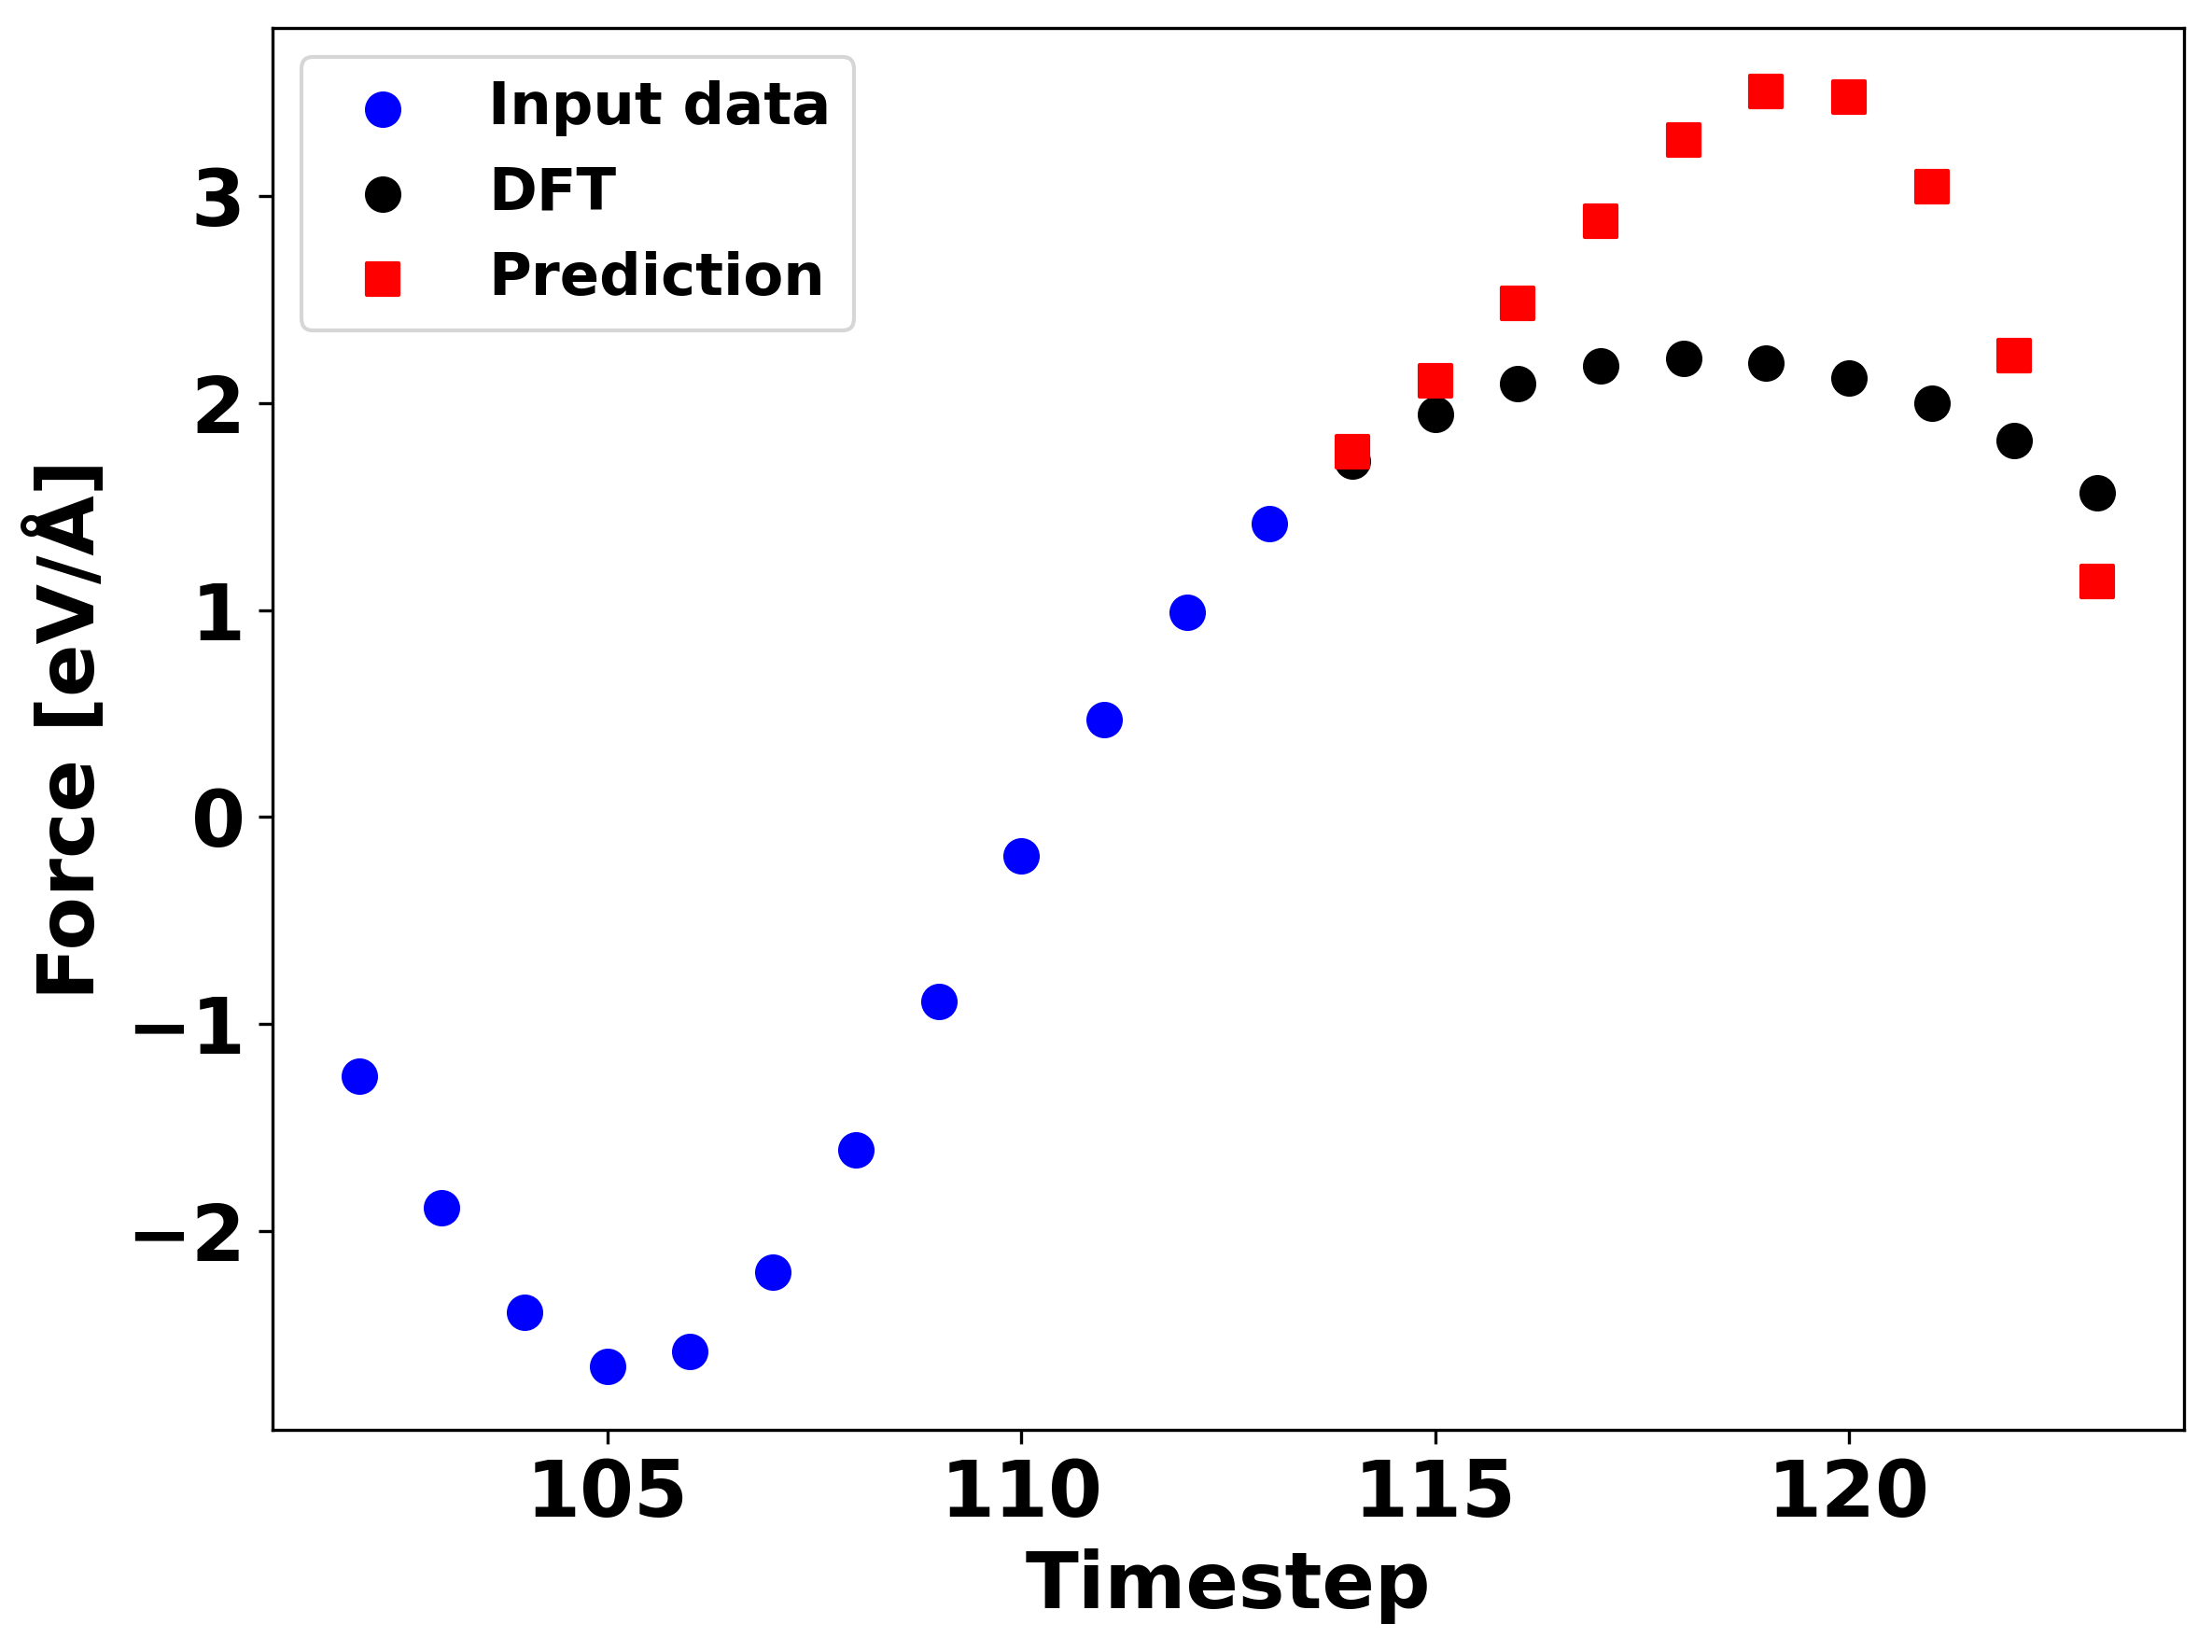

In [5]:
shift = 0
shift = 102
input = 12
pred_step = 10
max_lag = 2


#==========================
alpha = 0
mol = read(file, index=slice(input+shift, input+pred_step+shift))

predicted_forces = predict_forces(read(file, index=slice(0+shift, input+shift)), input=input, pred_step=pred_step, max_lag=max_lag, alpha=alpha)
mae = []
for i in range(pred_step):
    force_ref = mol[i].get_forces()
    pred_force = predicted_forces[i, :].reshape(9, 3)
    error = force_ref-pred_force
    mae.append(np.mean(np.abs(error)))

step_1_error = np.abs(mol[0].get_forces()-predicted_forces[0,:].reshape(9, 3))
max_index = np.argmax(step_1_error)
force_df = pd.read_csv("Data\Model_test\moldyn_dataframe_data.csv")

#============================
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(shift, input+shift), force_df.iloc[shift:input+shift, max_index+1], label="Input data", s=70, color="blue")
ax.scatter(range(shift+input, input+pred_step+shift), force_df.iloc[shift+input:input+pred_step+shift, max_index+1], label="DFT", s=70, color="black")
ax.scatter(range(input+shift, input+pred_step+shift), predicted_forces[:,max_index], label="Prediction",s=70, color="red", marker="s")
ax.set_xlabel("Timestep")
ax.set_ylabel("Force [eV/Å]")
ax.minorticks_off()
plt.tight_layout()
plt.legend(fontsize=15)
plt.show()


mae of each predicted step
[0.018399486197723167, 0.07010998776359775, 0.17289933794279852, 0.3263241984550408, 0.5095815743776598, 0.6943358399521884, 0.858599647798801, 1.0073868486973032, 1.120568258443238, 1.196501203041004]
Absolute errors at 1st step
[[0.01325764 0.00935443 0.01033784]
 [0.00085294 0.00182073 0.01810164]
 [0.07037099 0.08223529 0.05907749]
 [0.00434133 0.00163111 0.00444868]
 [0.00182644 0.0116134  0.00708437]
 [0.01222483 0.00456141 0.00571429]
 [0.00279071 0.01962786 0.0223258 ]
 [0.00357999 0.00506826 0.00976348]
 [0.02899693 0.0392148  0.04656347]]
mae of each predicted step
[0.018382955740172516, 0.07365050402808357, 0.18277619604295645, 0.3468141799467084, 0.5625430133112911, 0.8052823774158262, 1.0414083996666388, 1.259440793715723, 1.4471212487118958, 1.6115573076904397]
Absolute errors at 1st step
[[0.00018128 0.01434307 0.00833341]
 [0.00230249 0.02093414 0.01234452]
 [0.03704061 0.0603466  0.03797106]
 [0.01137486 0.00379633 0.0004118 ]
 [0.0081866  0.

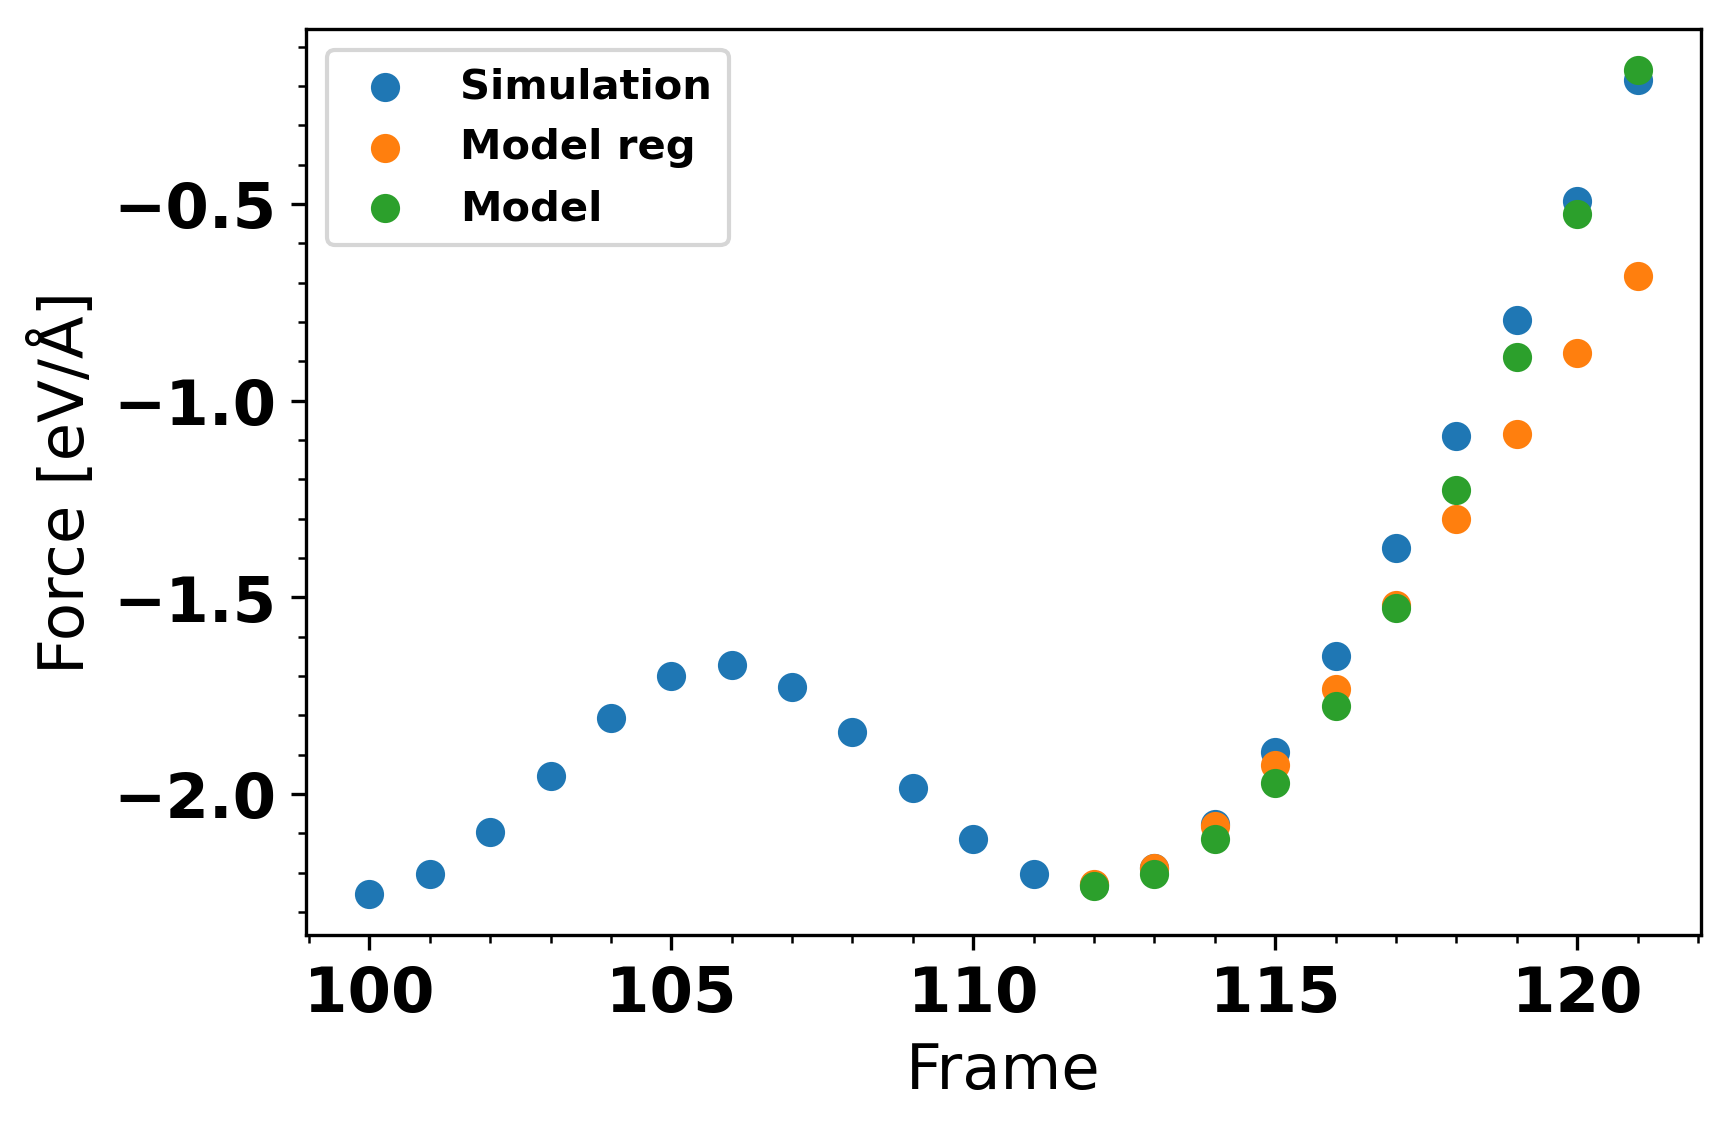

In [29]:
shift = 100
input = 12
pred_step = 10
max_lag = 2
alpha = 5e-3
mol = read(file, index=slice(input+shift, input+pred_step+shift))

predicted_forces = predict_forces(read(file, index=slice(0+shift, input+shift)), input=input, pred_step=pred_step, max_lag=max_lag, alpha=alpha)
mae = []
for i in range(pred_step):
    force_ref = mol[i].get_forces()
    pred_force = predicted_forces[i, :].reshape(9, 3)
    error = force_ref-pred_force
    mae.append(np.mean(np.abs(error)))
print("mae of each predicted step")
print(mae)
print("Absolute errors at 1st step")
step_1_error = np.abs(mol[0].get_forces()-predicted_forces[0,:].reshape(9, 3))
print(step_1_error)
max_index = np.argmax(step_1_error)

force_df = pd.read_csv("Data\Model_test\moldyn_dataframe_data.csv")
plt.scatter(range(shift, input+pred_step+shift), force_df.iloc[shift:input+pred_step+shift, max_index+1], label="Simulation")
plt.scatter(range(input+shift, input+pred_step+shift), predicted_forces[:,max_index], label="Model reg")

#==========================
alpha = 0
mol = read(file, index=slice(input+shift, input+pred_step+shift))

predicted_forces = predict_forces(read(file, index=slice(0+shift, input+shift)), input=input, pred_step=pred_step, max_lag=max_lag, alpha=alpha)
mae = []
for i in range(pred_step):
    force_ref = mol[i].get_forces()
    pred_force = predicted_forces[i, :].reshape(9, 3)
    error = force_ref-pred_force
    mae.append(np.mean(np.abs(error)))
print("mae of each predicted step")
print(mae)
print("Absolute errors at 1st step")
step_1_error = np.abs(mol[0].get_forces()-predicted_forces[0,:].reshape(9, 3))
print(step_1_error)

force_df = pd.read_csv("Data\Model_test\moldyn_dataframe_data.csv")
# plt.scatter(range(shift, input+pred_step+shift), force_df.iloc[shift:input+pred_step+shift, max_index+1], label="Simulation")
#============================

plt.scatter(range(input+shift, input+pred_step+shift), predicted_forces[:,max_index], label="Model")
plt.xlabel("Frame")
plt.ylabel("Force [eV/Å]")
plt.legend()
plt.show()


# Evaluate models

In [5]:
def evaluate_model(mol, input=6, pred_step=6, dt=0.5*units.fs, method="SVD", max_lag=2, alpha=0, mode="Force"):
    mae = np.zeros(pred_step)
    dft_forces = []
    pred_forces = []
    k=0
    n=0
    while k < len(mol)-input-pred_step-20:
        predicted_forces = predict_forces(mol[k:k+input], input=input, pred_step=pred_step, max_lag=max_lag, alpha=alpha, method=method)
        temp_mol = mol[k+input-1]
        mae_step = []
        #Repurposing the step function from ASE velverlet
        for i in range(pred_step+1):
            #Get masses for the atoms in the molecule
            masses = temp_mol.get_masses()[:, np.newaxis]

            #Get the forces, momenta, and positions for the current step
            #forces = mol[i].get_forces()
            if i == 0:
                forces = temp_mol.get_forces()
            else:
                forces = predicted_forces[i-1,:] 
                forces = forces.reshape(temp_mol.get_global_number_of_atoms(), 3)
                
            p = temp_mol.get_momenta()
            r = temp_mol.get_positions()
            
            #Calculate new momenta and positions
            p += 0.5 * dt * forces
            temp_mol.set_positions(r + dt * p / masses)
            
            if i != 0:
                pred_forces.append(forces)
                dft_forces.append(mol[k+input+i-1].get_forces())
                if mode == "Force":
                    error = mol[k+input+i-1].get_forces()-forces
                    mae_step.append(np.mean(np.abs(error)))
                elif mode =="Positions":
                    error = temp_mol.get_positions()-mol[k+input+i].get_positions()
                    mae_step.append(np.mean(np.abs(error)))
                else:
                    print("Please choose a valid mode, either 'Force' or 'Positions'")
            #Was in ase.step. Unsure if needed
            if temp_mol.constraints:
                p = (temp_mol.get_positions() - r) * masses / dt

            #Momenta needs to be stored before possible calculations of forces
            temp_mol.set_momenta(p, apply_constraint=False)

            #Forces for next step is found either using predicted forces or gpaw calculator
            if i<pred_step:
                forces = predicted_forces[i,:] 
                forces = forces.reshape(temp_mol.get_global_number_of_atoms(), 3)
            #else:
                #forces = mol.get_forces(md=True)
            
            #Calculate and set momenta for the next step
            temp_mol.set_momenta(temp_mol.get_momenta() + 0.5 * dt * forces)
        k+=input+pred_step
        mae += np.asarray(mae_step)
        n+=1
    
    return mae/n, pred_forces, dft_forces

In [6]:
mol = read(file, index=":")
mae, pred, DFT = evaluate_model(mol, input=12, pred_step=6, max_lag=2, mode="Force")
print(mae)


[0.01264606 0.04180898 0.09551026 0.17891651 0.29224876 0.43030722]


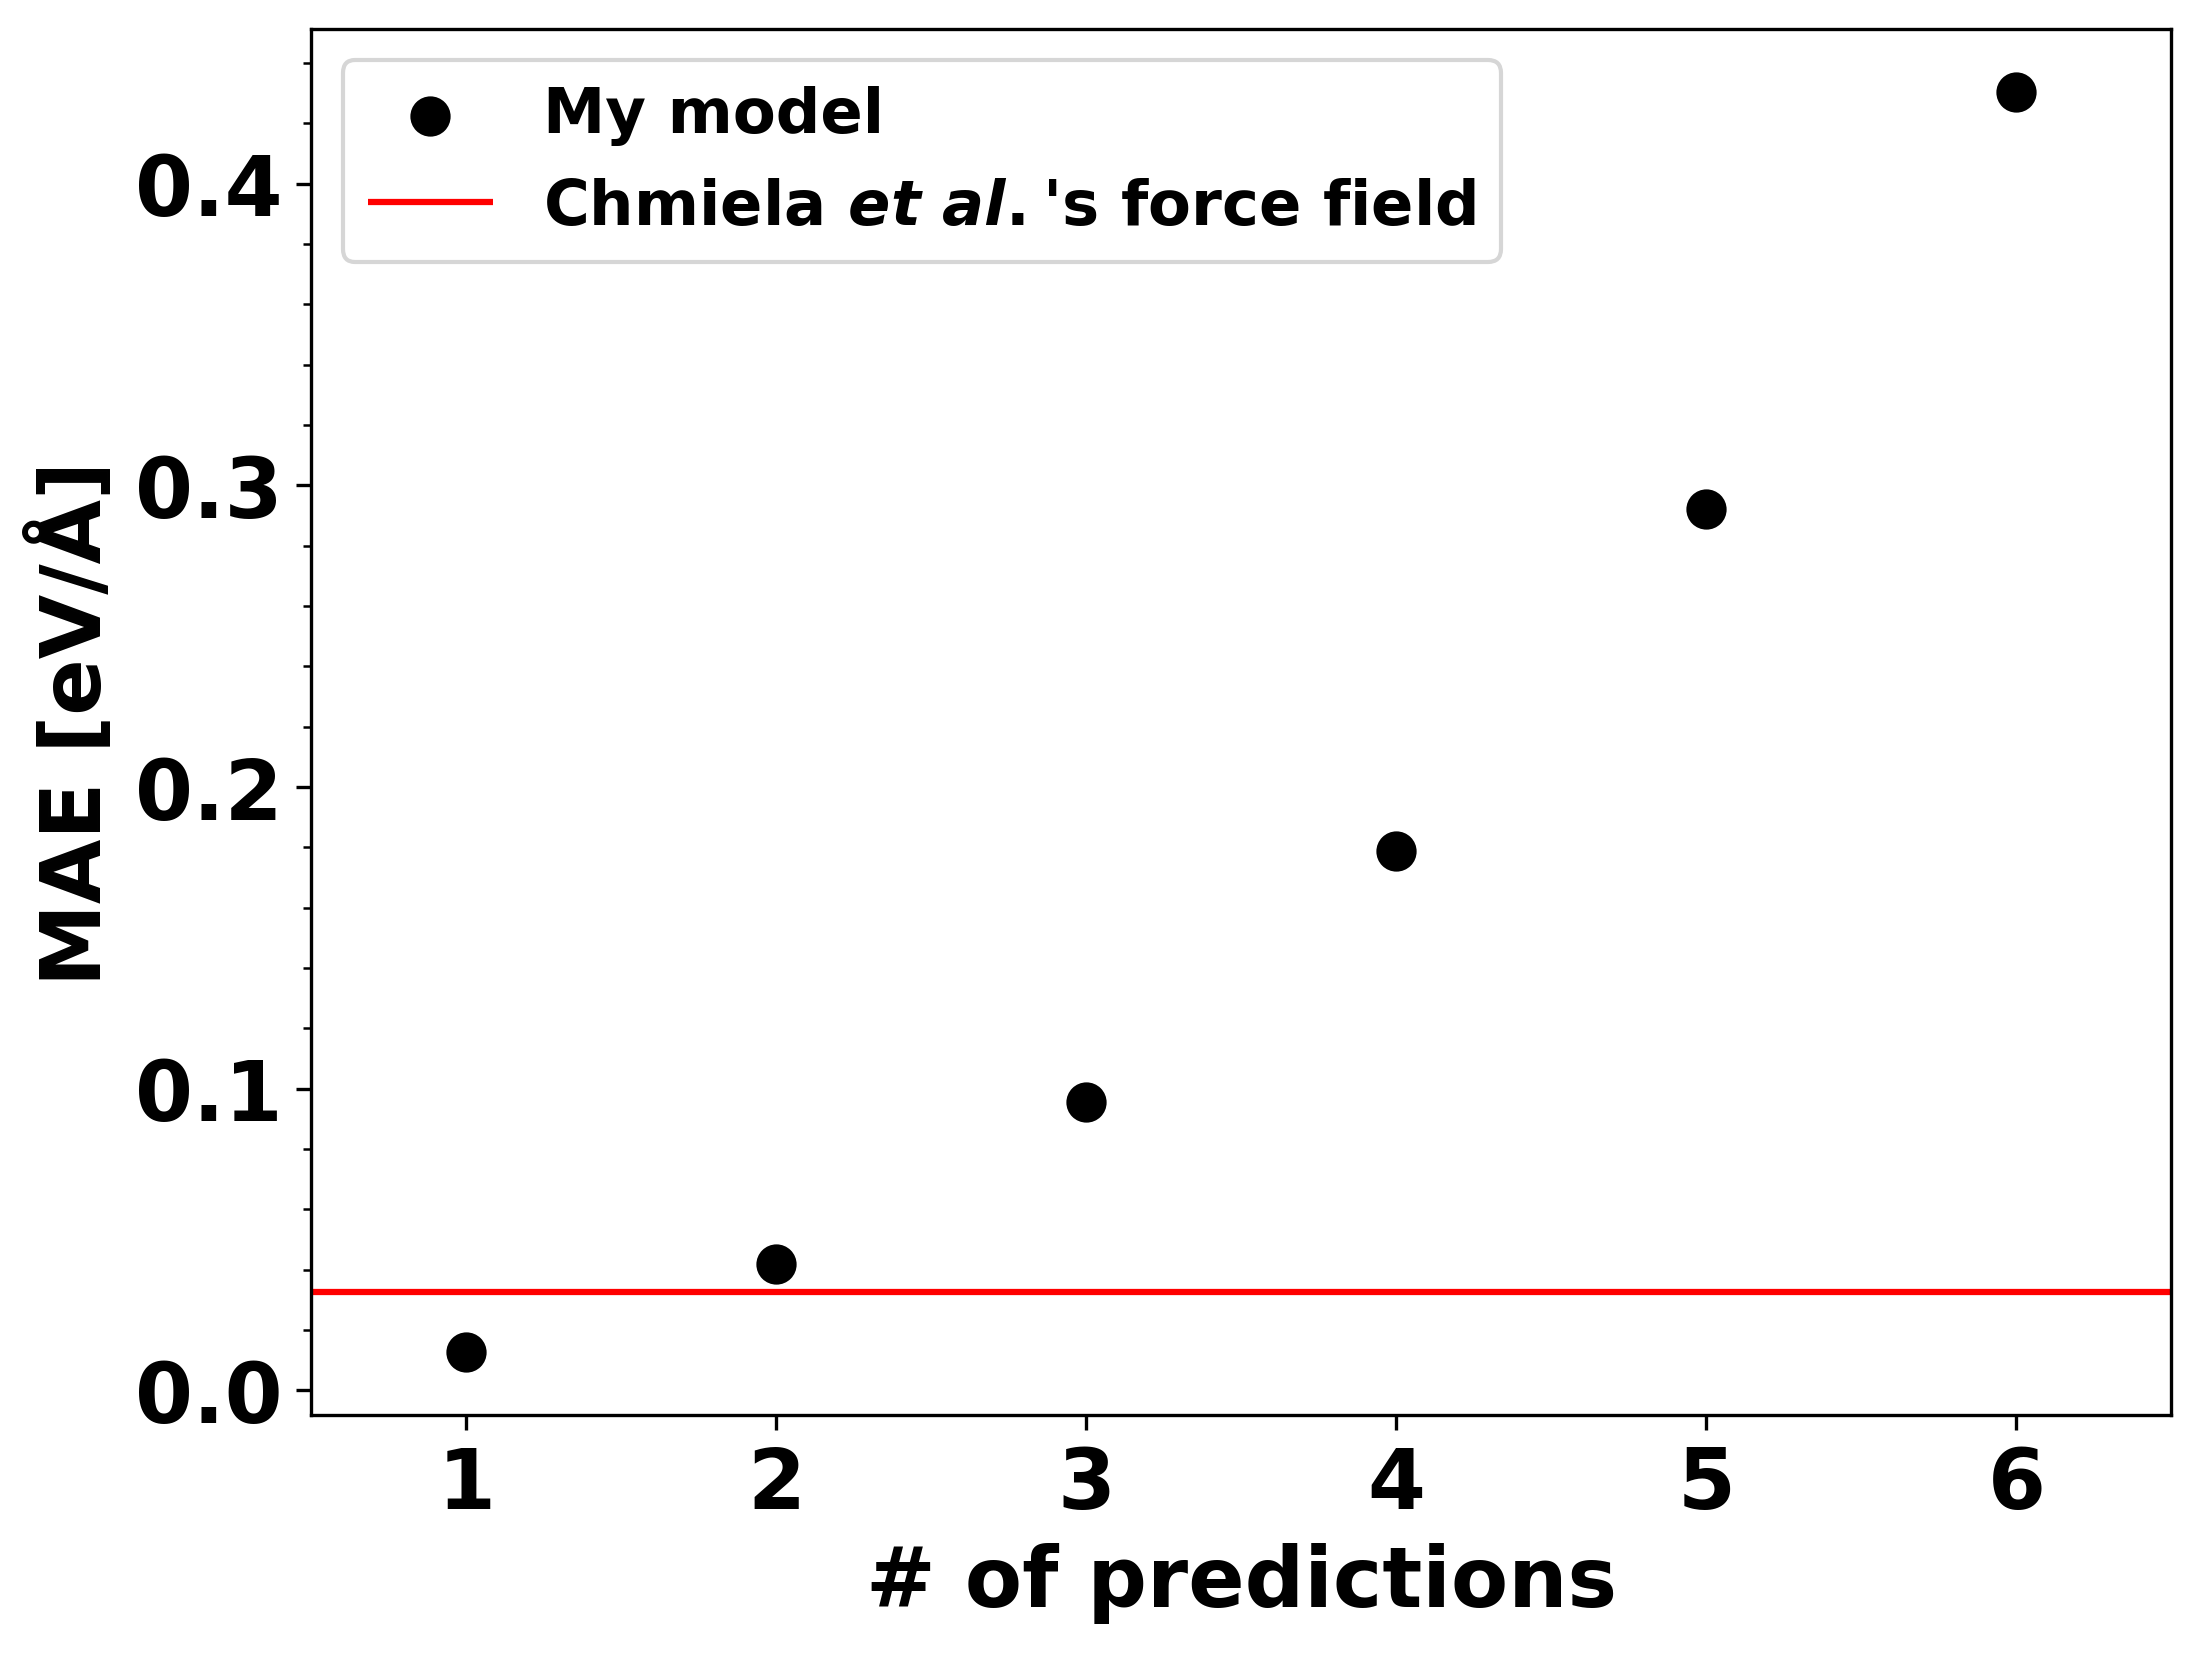

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(range(1, 7), mae[:6], color="black", s=75, label="My model")
ax.set_xlabel("# of predictions")
ax.set_ylabel('MAE [eV/Å]')
ax.tick_params(which="minor", bottom = False) 
ax.hlines(0.0325, -1, 7, color="red", label="Chmiela $\it{et}$ $\it{al.}$'s force field")
ax.set_xlim(0.5, 6.5)
plt.legend(fontsize=15)
plt.show()

In [18]:
print(np.array(pred).shape)

(1679, 9, 3)


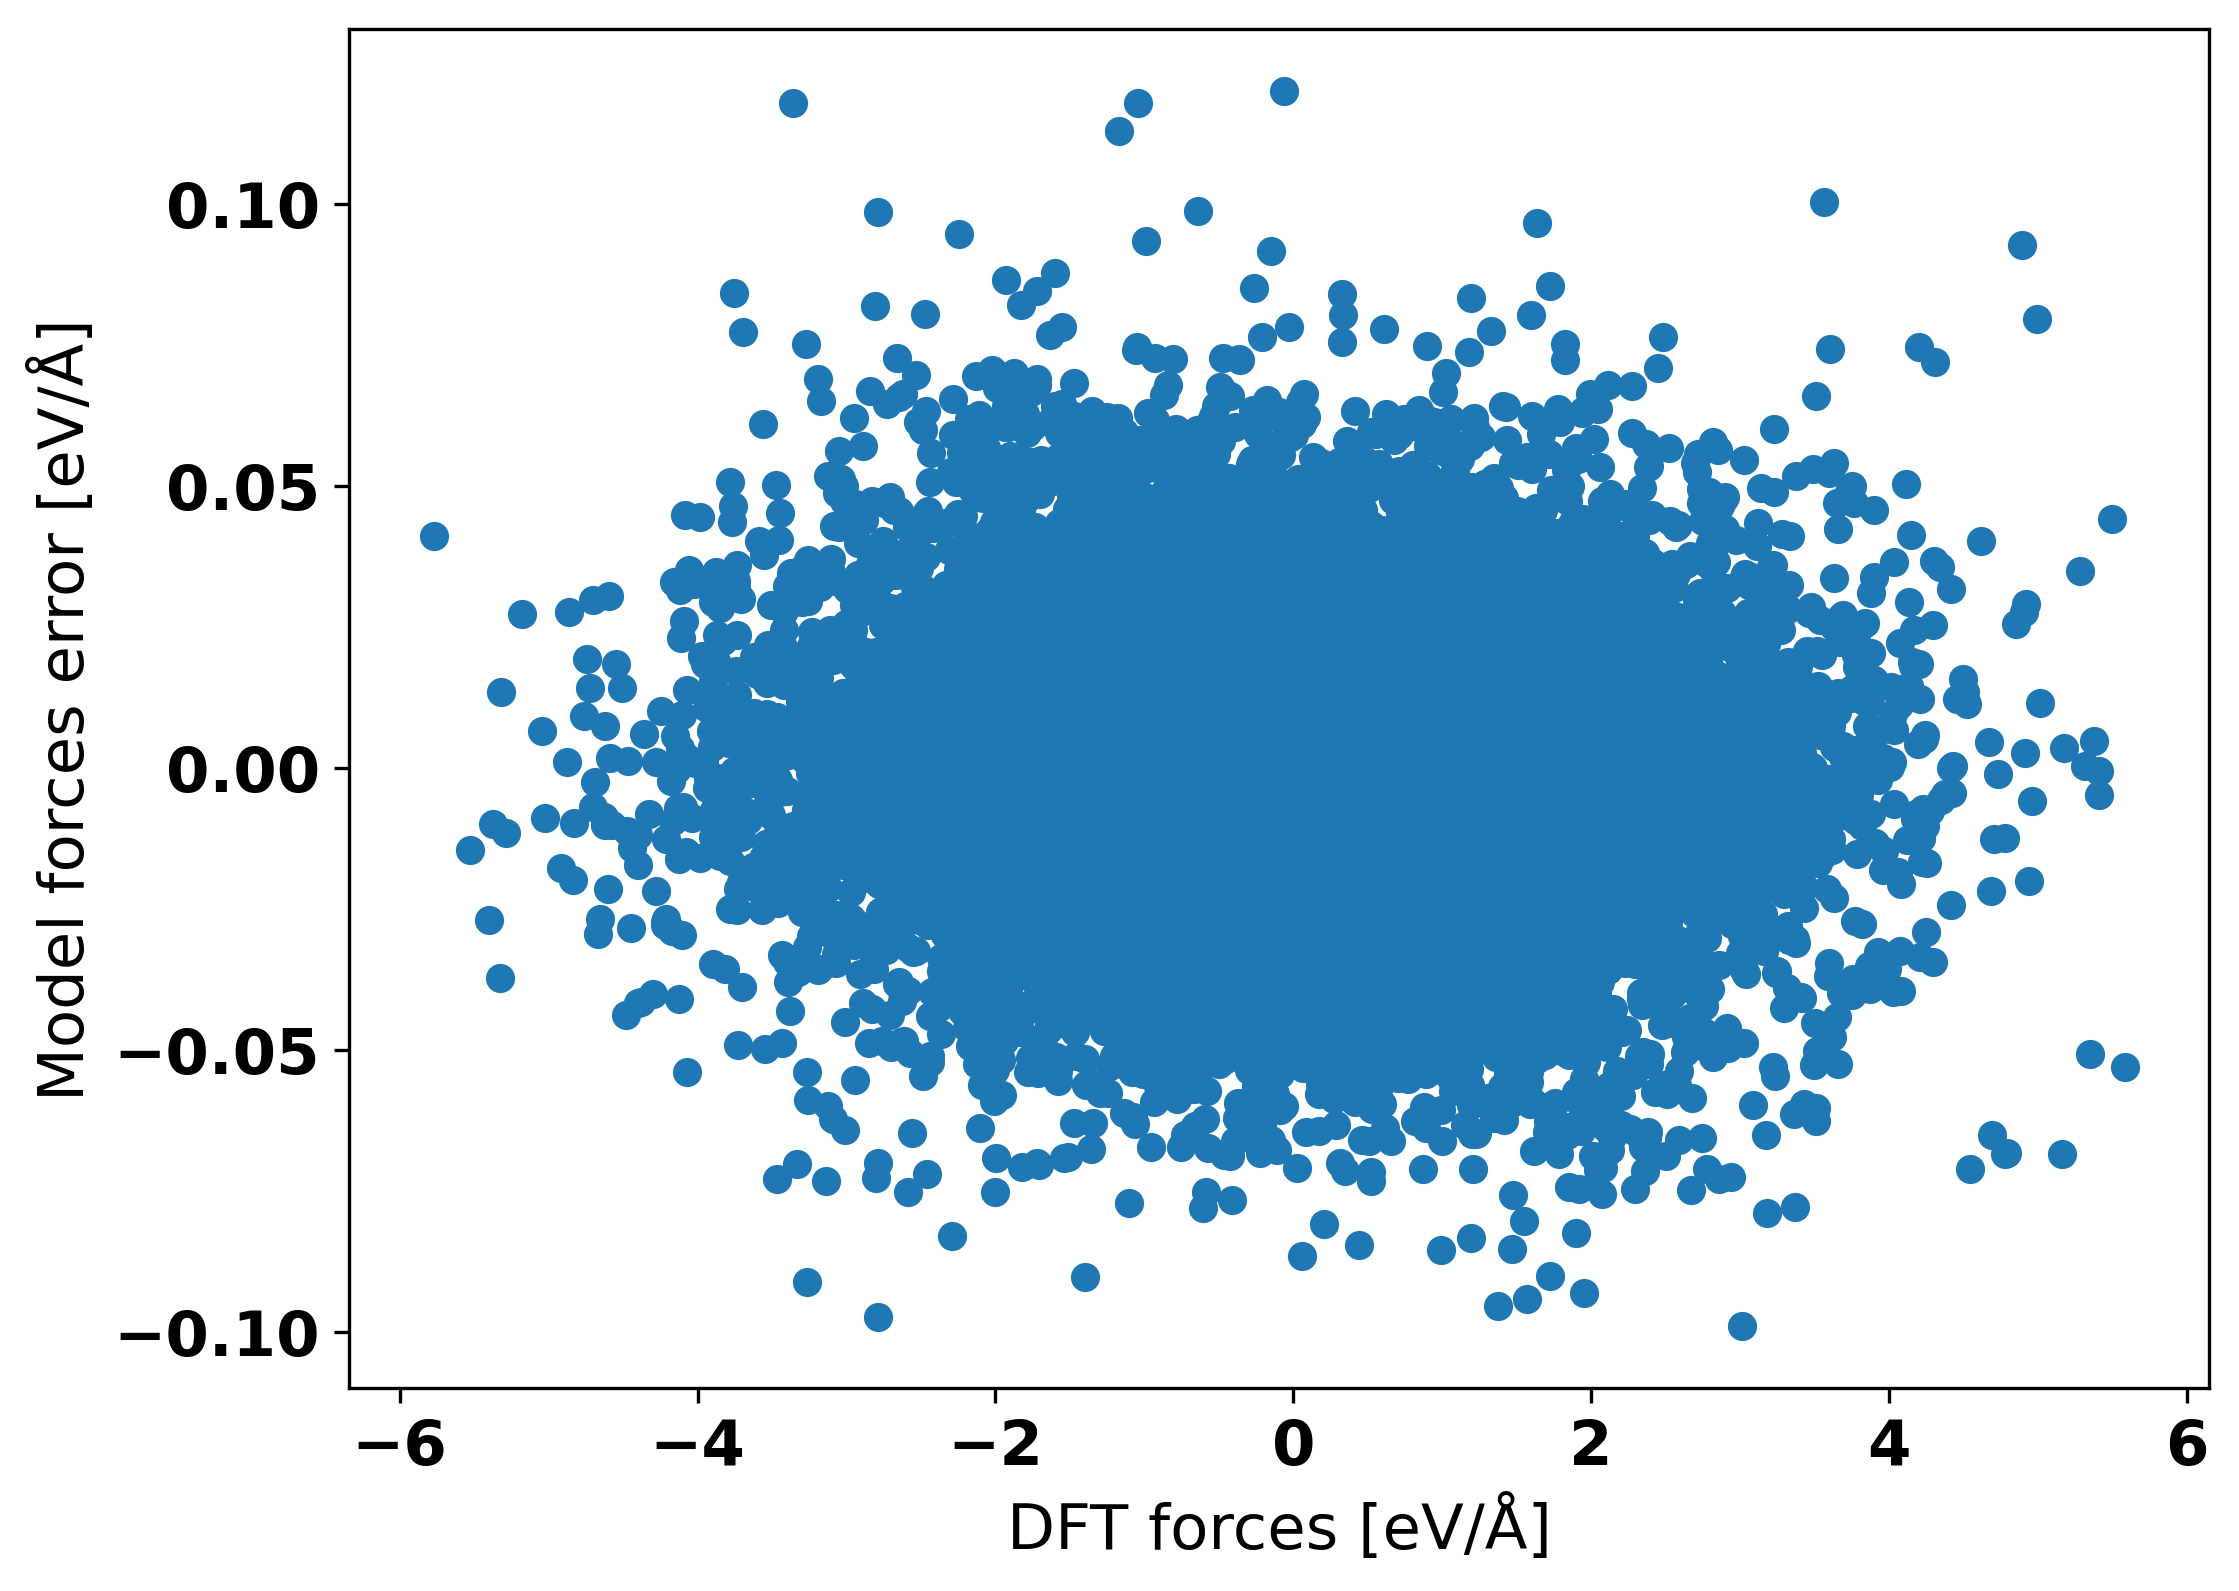

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(DFT, np.asarray(DFT)-np.asarray(pred))
ax.set_xlabel("DFT forces [eV/Å]")
ax.set_ylabel("Model forces error [eV/Å]")
ax.minorticks_off()
plt.show()

0.012605601608608595


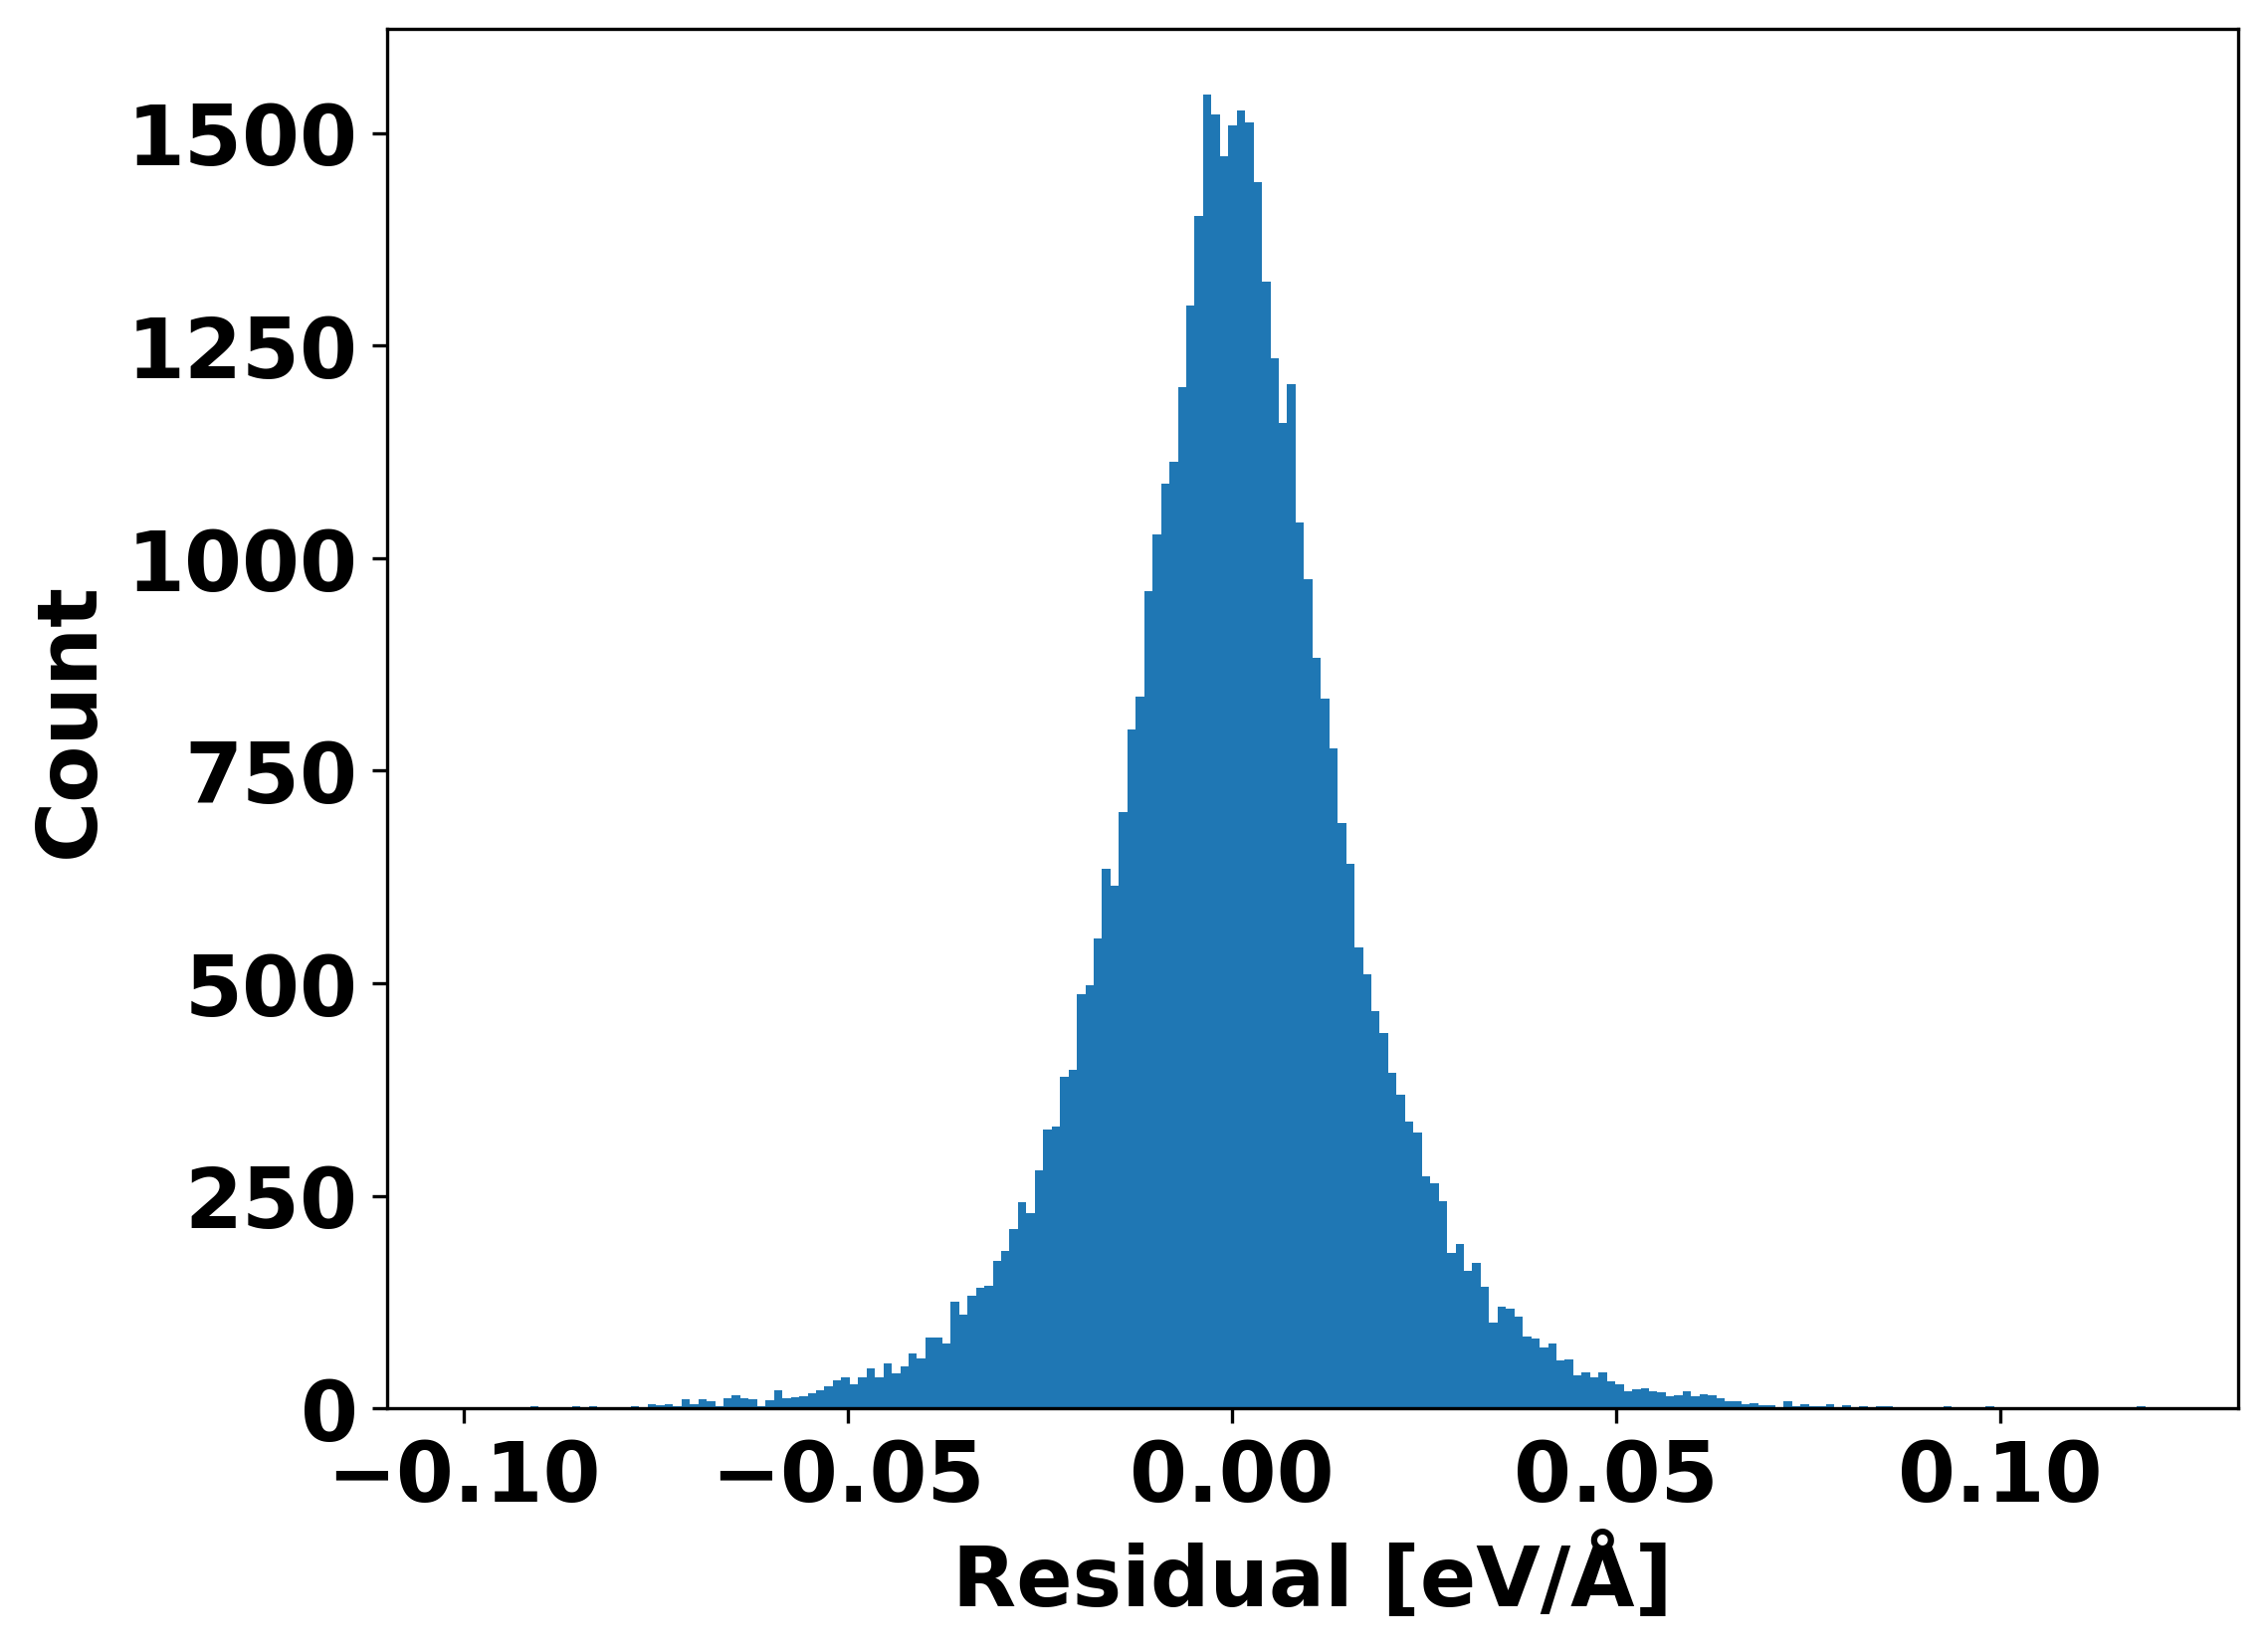

In [29]:
nbins = 200
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist((np.asarray(DFT)-np.asarray(pred)).flatten(), bins=nbins)
print(np.mean(np.abs(np.asarray(DFT)-np.asarray(pred))))
ax.set_xlabel("Residual [eV/Å]")
ax.set_ylabel("Count")
ax.minorticks_off()
plt.show()

In [55]:
inputs = [12, 13, 13, 15, 8, 9]
max_lags = [2, 4, 5, 5, 3, 2]
alpha = 0.0001163265306122449
for i in range(len(inputs)):

    mol = read(file, index=":")
    print(f"input = {inputs[i]}, max lag = {max_lags[i]}", evaluate_model(mol, input=inputs[i], pred_step=1, max_lag=max_lags[i])[0])
    mol = read(file, index=":")
    print(f"input = {inputs[i]}, max lag = {max_lags[i]}, regularized", evaluate_model(mol, input=inputs[i], pred_step=1, max_lag=max_lags[i], alpha=alpha)[0])


input = 12, max lag = 2 [0.0126056]
input = 12, max lag = 2, regularized [0.01253187]
input = 13, max lag = 4 [0.01198374]
input = 13, max lag = 4, regularized [0.01199245]
input = 13, max lag = 5 [0.01197585]
input = 13, max lag = 5, regularized [0.01199085]
input = 15, max lag = 5 [0.0120528]
input = 15, max lag = 5, regularized [0.01206022]
input = 8, max lag = 3 [0.01255089]
input = 8, max lag = 3, regularized [0.01264105]
input = 9, max lag = 2 [0.01273129]
input = 9, max lag = 2, regularized [0.01288293]


# SVD
### No regularization

In [42]:
mae = np.zeros((10, 8, 10))
# Remove the range for pred, just run it once and then calculate the error for each prediction step
for i in range(10):
    print(i)
    for k in range(10):
        mol_mae = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':2000')
        if i+6 <= k+1:
            mae[i, :, k] = 1
        else:
            mae[i, :, k] = evaluate_model(mol=mol_mae, input=i+6, pred_step=8, method="SVD", max_lag=k+1, mode="Positions")[0]


0
1
2
3
4
5
6
7
8
9


In [2]:
#np.save("SVD_no_regularization", mae)
mae = np.load("SVD_no_regularization.npy")

In [12]:
def smallestN_indices(a, N, maintain_order=False):
    idx = np.argpartition(a.ravel(),N)[:N]
    if maintain_order:
        idx = idx[a.ravel()[idx].argsort()]
    return np.stack(np.unravel_index(idx, a.shape)).T
print(smallestN_indices(mae, 5, maintain_order=True))
print(np.where(mae[:,0,:]==mae[:,0,:].min()))

print(mae[:,0,:].min())

[[4 0 6]
 [4 0 5]
 [4 0 3]
 [4 0 4]
 [4 0 2]]
(array([4], dtype=int64), array([6], dtype=int64))
0.014603144674490216


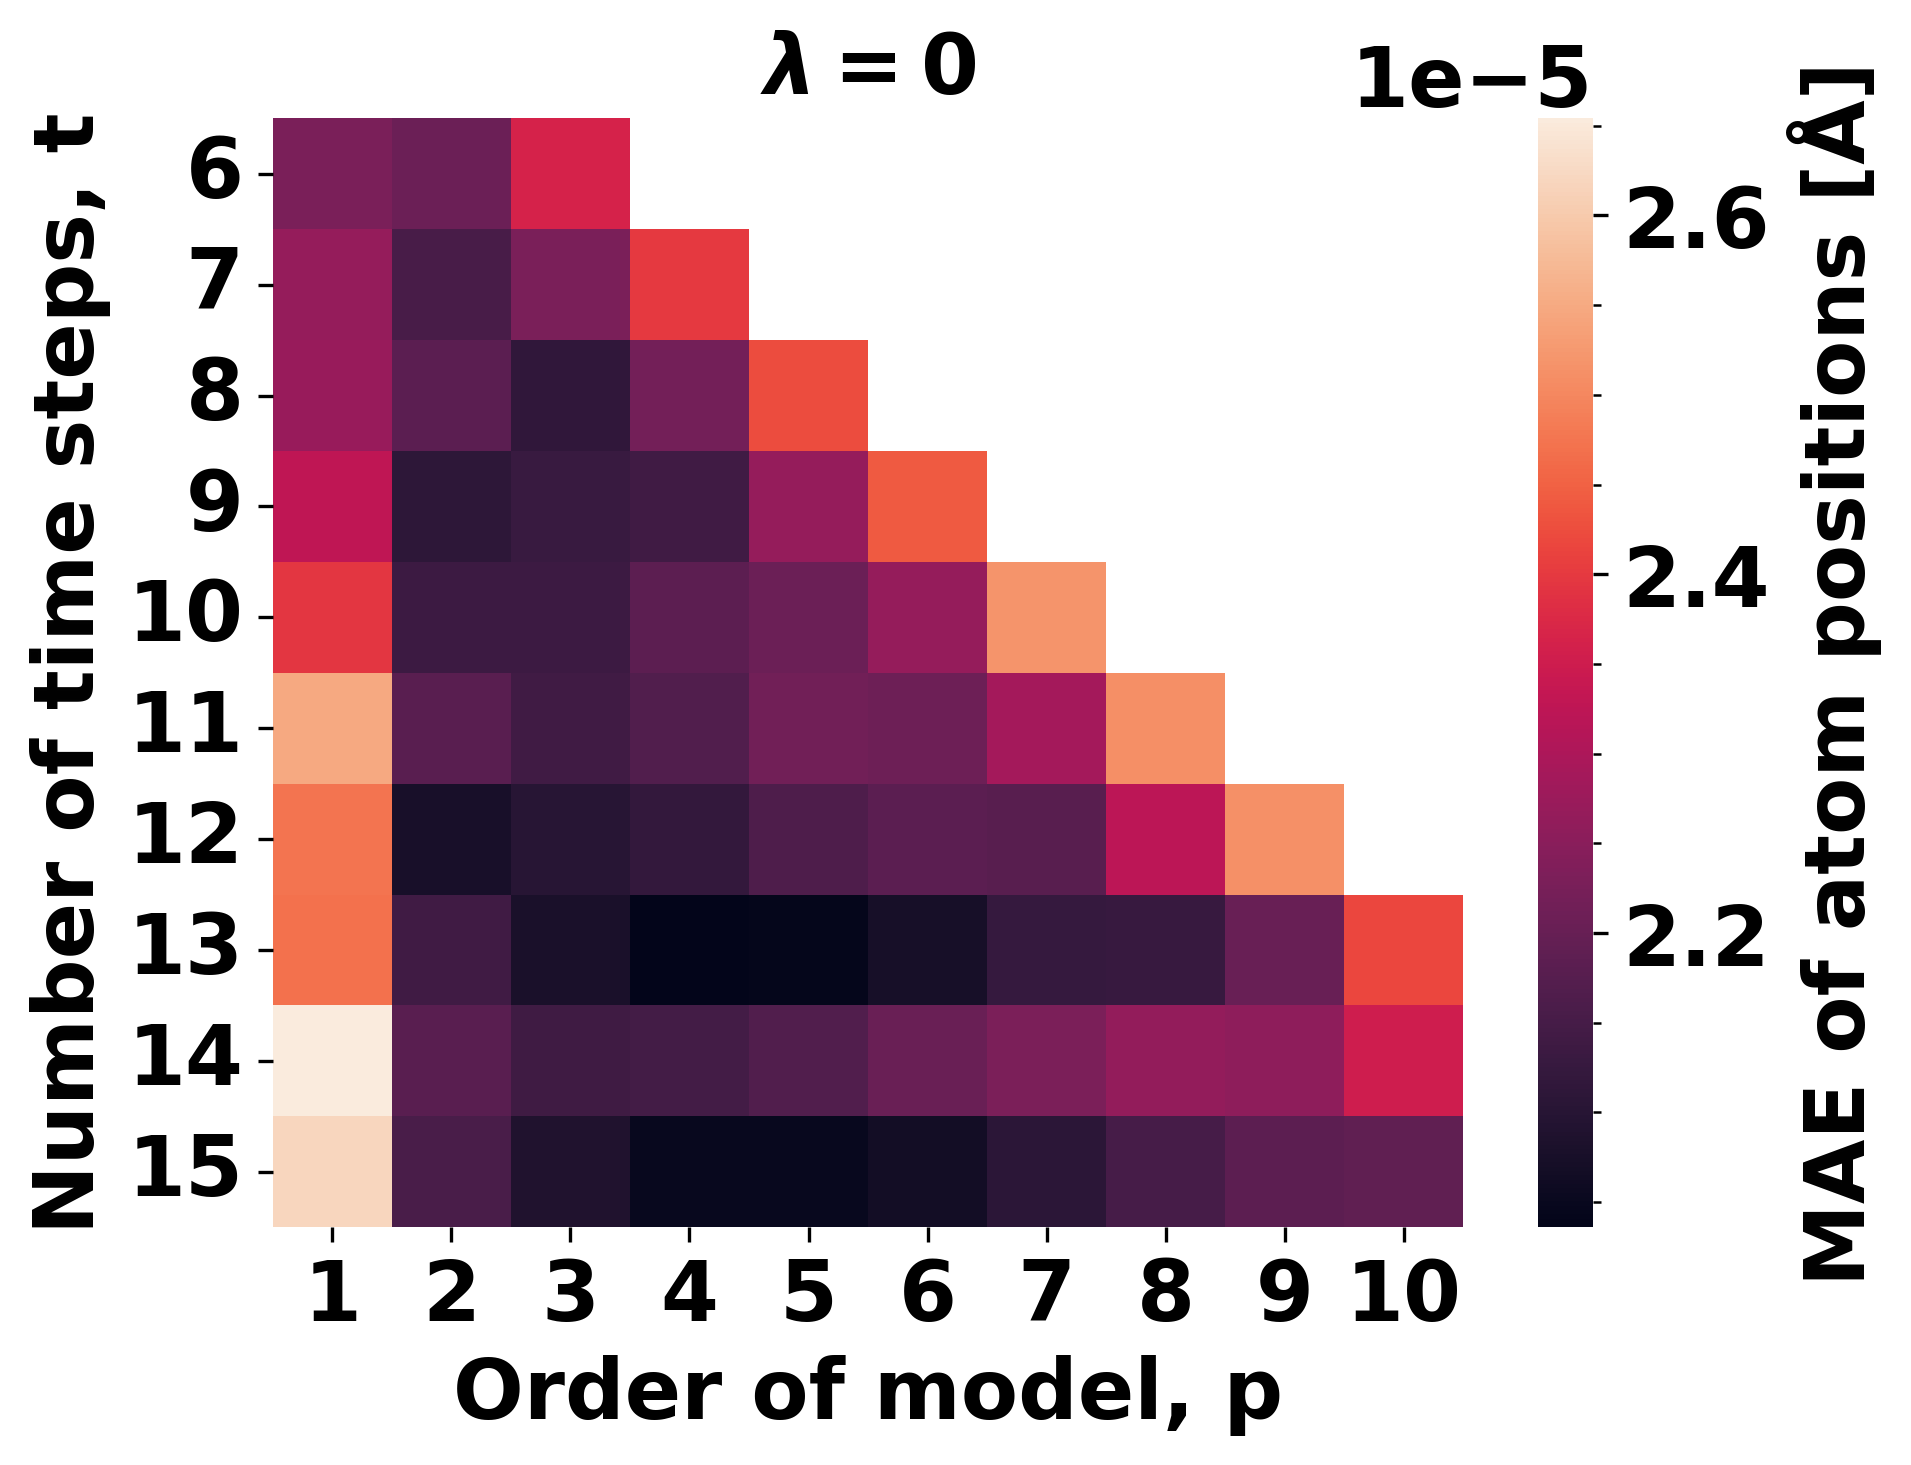

In [4]:
#ax = sns.heatmap(np.mean(mae[:,:2,:], axis=1)[2:, :], cbar_kws={'label':"MAE of position of atoms"})
mae_edited = mae
for i in range(6):
    mae_edited[i, :, i+4] = 1
for i in range(7):
    mae_edited[i, :, i+3] = 1
ax = sns.heatmap(mae_edited[:,0, :], cbar_kws={'label':"MAE of atom positions [Å]"}, mask = mae_edited[:,0,:]==1)
ax.set(xlabel="Order of model, p", ylabel="Number of time steps, t")
ax.set_title("$\lambda = 0$", fontweight="bold")
ax.set_yticklabels(range(6, 16))
ax.set_xticklabels(range(1, 11))
plt.yticks(rotation=0)
ax.minorticks_off()

Parameters to try:

input = 8, max_lag = 3 

input = 9, max_lag = 2

input = 12, max_lag = 2

input = 13, max_lag = 4

input = 13, max_lag = 5

input = 15, max_lag = 5

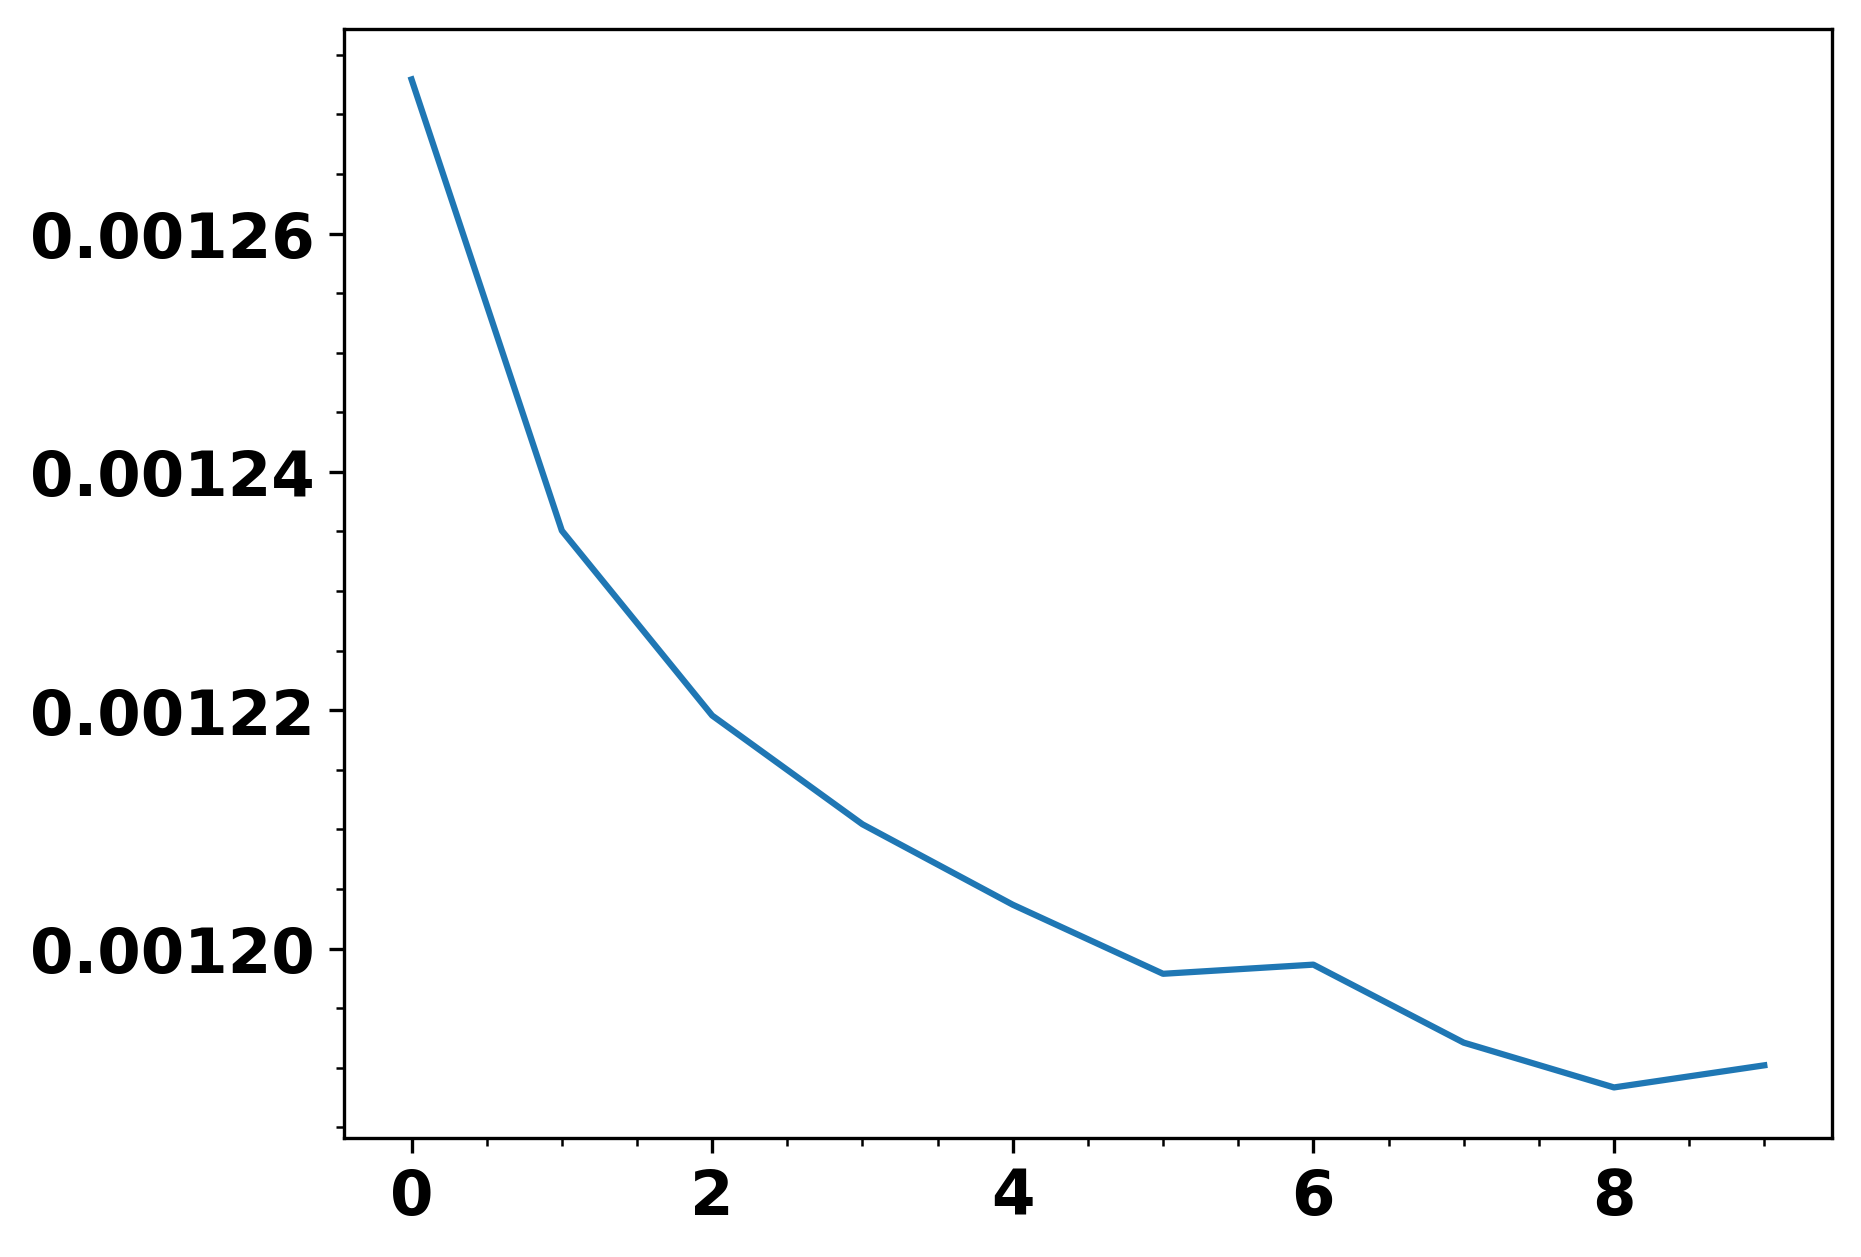

In [79]:

plt.plot(range(10), np.mean(mae[:,2,:], axis=(0), where=mae[:,2,:]!=1))

In [7]:
mol_mae = read("Data/Heavy_molecules/Cholesterol_moldyn_data_700.xyz", index=':')
print(len(mol_mae))

2849


### Regularization

In [11]:
resolution = 30
mae = np.zeros((6, 6, 5, resolution))

min = 0.0005
# Remove the range for pred, just run it once and then calculate the error for each prediction step
for i in range(10):
    print(i)
    for k in range(10):
        j = 0
        for alpha in np.linspace(0, min, resolution):
            j += 1
            mol_mae = read("Data/Heavy_molecules/Aspirin_moldyn_data_700.xyz", index=':')
            #try:
            if i+6<=k+1:
                mae[i, :, k, j-1] = 1
            else:
                mae[i, :, k, j-1] = evaluate_model(mol=mol_mae, input=i+10, pred_step=6, method="SVD", max_lag=k+1, alpha=alpha)[0]
            #except:
            #   print(i+6, 8, k+1)

0


KeyboardInterrupt: 

In [33]:
#np.save("SVD_aspirin_regularization_mae.npy", mae)
#mae_save = mae
mae = np.load("SVD_aspirin_regularization_mae.npy")
print(mae.shape)
print(mae)

(6, 6, 5, 30)
[[[[0.01482244 0.01478753 0.01476945 ... 0.01531985 0.01534727
    0.01537457]
   [0.01398412 0.01398597 0.01398998 ... 0.01429587 0.01431054
    0.0143253 ]
   [0.0138603  0.01386558 0.01387137 ... 0.01409991 0.01411019
    0.01412049]
   [0.01416296 0.01416841 0.01417412 ... 0.01435523 0.01436338
    0.01437157]
   [0.01424753 0.01425239 0.0142573  ... 0.01439834 0.01440432
    0.01441028]]

  [[0.05299389 0.05286844 0.05278103 ... 0.05382282 0.05388852
    0.05395424]
   [0.04919125 0.04919266 0.04919848 ... 0.04989331 0.04992834
    0.04996342]
   [0.04861948 0.04863171 0.04864512 ... 0.04915682 0.04918116
    0.04920564]
   [0.04967372 0.04968601 0.04969896 ... 0.05013384 0.05015417
    0.05017464]
   [0.0501859  0.05019823 0.05021063 ... 0.05056132 0.05057626
    0.05059121]]

  [[0.12572501 0.12539263 0.12514505 ... 0.12622057 0.12633531
    0.12645009]
   [0.11478758 0.11478151 0.11478272 ... 0.11590877 0.11596786
    0.11602714]
   [0.11232778 0.11234432 0.112363

In [12]:
min_alpha = []
for i in range(6):
    for k in range(5):
        index = np.where((mae[i,0,k, :]==mae[i,0,k, :].min()))
        min_alpha.append(np.linspace(0, min, 50)[index[0]])

print(min_alpha)  

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.02040816e-05]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([3.06122449e-05]), array([0.]), array([0.]), array([0.]), array([0.]), array([5.10204082e-05]), array([1.02040816e-05]), array([0.]), array([0.]), array([0.]), array([4.08163265e-05]), array([0.]), array([0.]), array([0.]), array([0.])]


In [34]:
print(np.where(np.mean(mae[:,:6,:, :], axis=(1))==np.mean(mae[:,:6,:, :], axis=(1)).min()))
print(np.where(mae[:,0,:, 0]==mae[:,0,:, 0].min()))
print(np.linspace(0, min, 50)[7])

(array([3], dtype=int64), array([4], dtype=int64), array([0], dtype=int64))
(array([3], dtype=int64), array([3], dtype=int64))
7.142857142857143e-05


In [19]:
print(np.where(mae[:,0,:, :]==mae[:,0,: :].min()))
print(np.where(mae[:,:,:,:]==mae[:,:,:,:].min()))
print(np.where(np.mean(mae[:,0,:, :], axis=(0, 1), where=mae[:,0,:,:]!=1)==np.mean(mae[:,0,:, :], axis=(0, 1), where=mae[:,0,:,:]!=1).min()))
print(np.where(np.mean(mae[:,0,:, :], axis=(0, 2), where=mae[:,0,:,:]!=1)==np.mean(mae[:,0,:, :], axis=(0, 2), where=mae[:,0,:,:]!=1).min()))
print(np.where(np.mean(mae[:,0,:, :], axis=(1, 2), where=mae[:,0,:,:]!=1)==np.mean(mae[:,0,:, :], axis=(1, 2), where=mae[:,0,:,:]!=1).min()))
print(np.linspace(0, min, 30)[2])
print(mae.min())
print(mae[5, 0, 2, 0])

(array([5], dtype=int64), array([2], dtype=int64), array([0], dtype=int64))
(array([5], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([0], dtype=int64))
(array([0], dtype=int64),)
(array([2], dtype=int64),)
(array([4], dtype=int64),)
3.4482758620689657e-05
0.011792944817560219
0.011792944817560219


In [ ]:
#ax = sns.heatmap(np.mean(mae[:,:2,:], axis=1)[2:, :], cbar_kws={'label':"MAE of position of atoms"})
ax = sns.heatmap(mae[2:,0, :], cbar_kws={'label':"MAE of position of atoms"})
ax.set(xlabel="Number of time lags", ylabel="Number of input")
#ax.set_yticklabels(range(8, 16))
#ax.set_xticklabels(range(1, 7))

ax.minorticks_off()

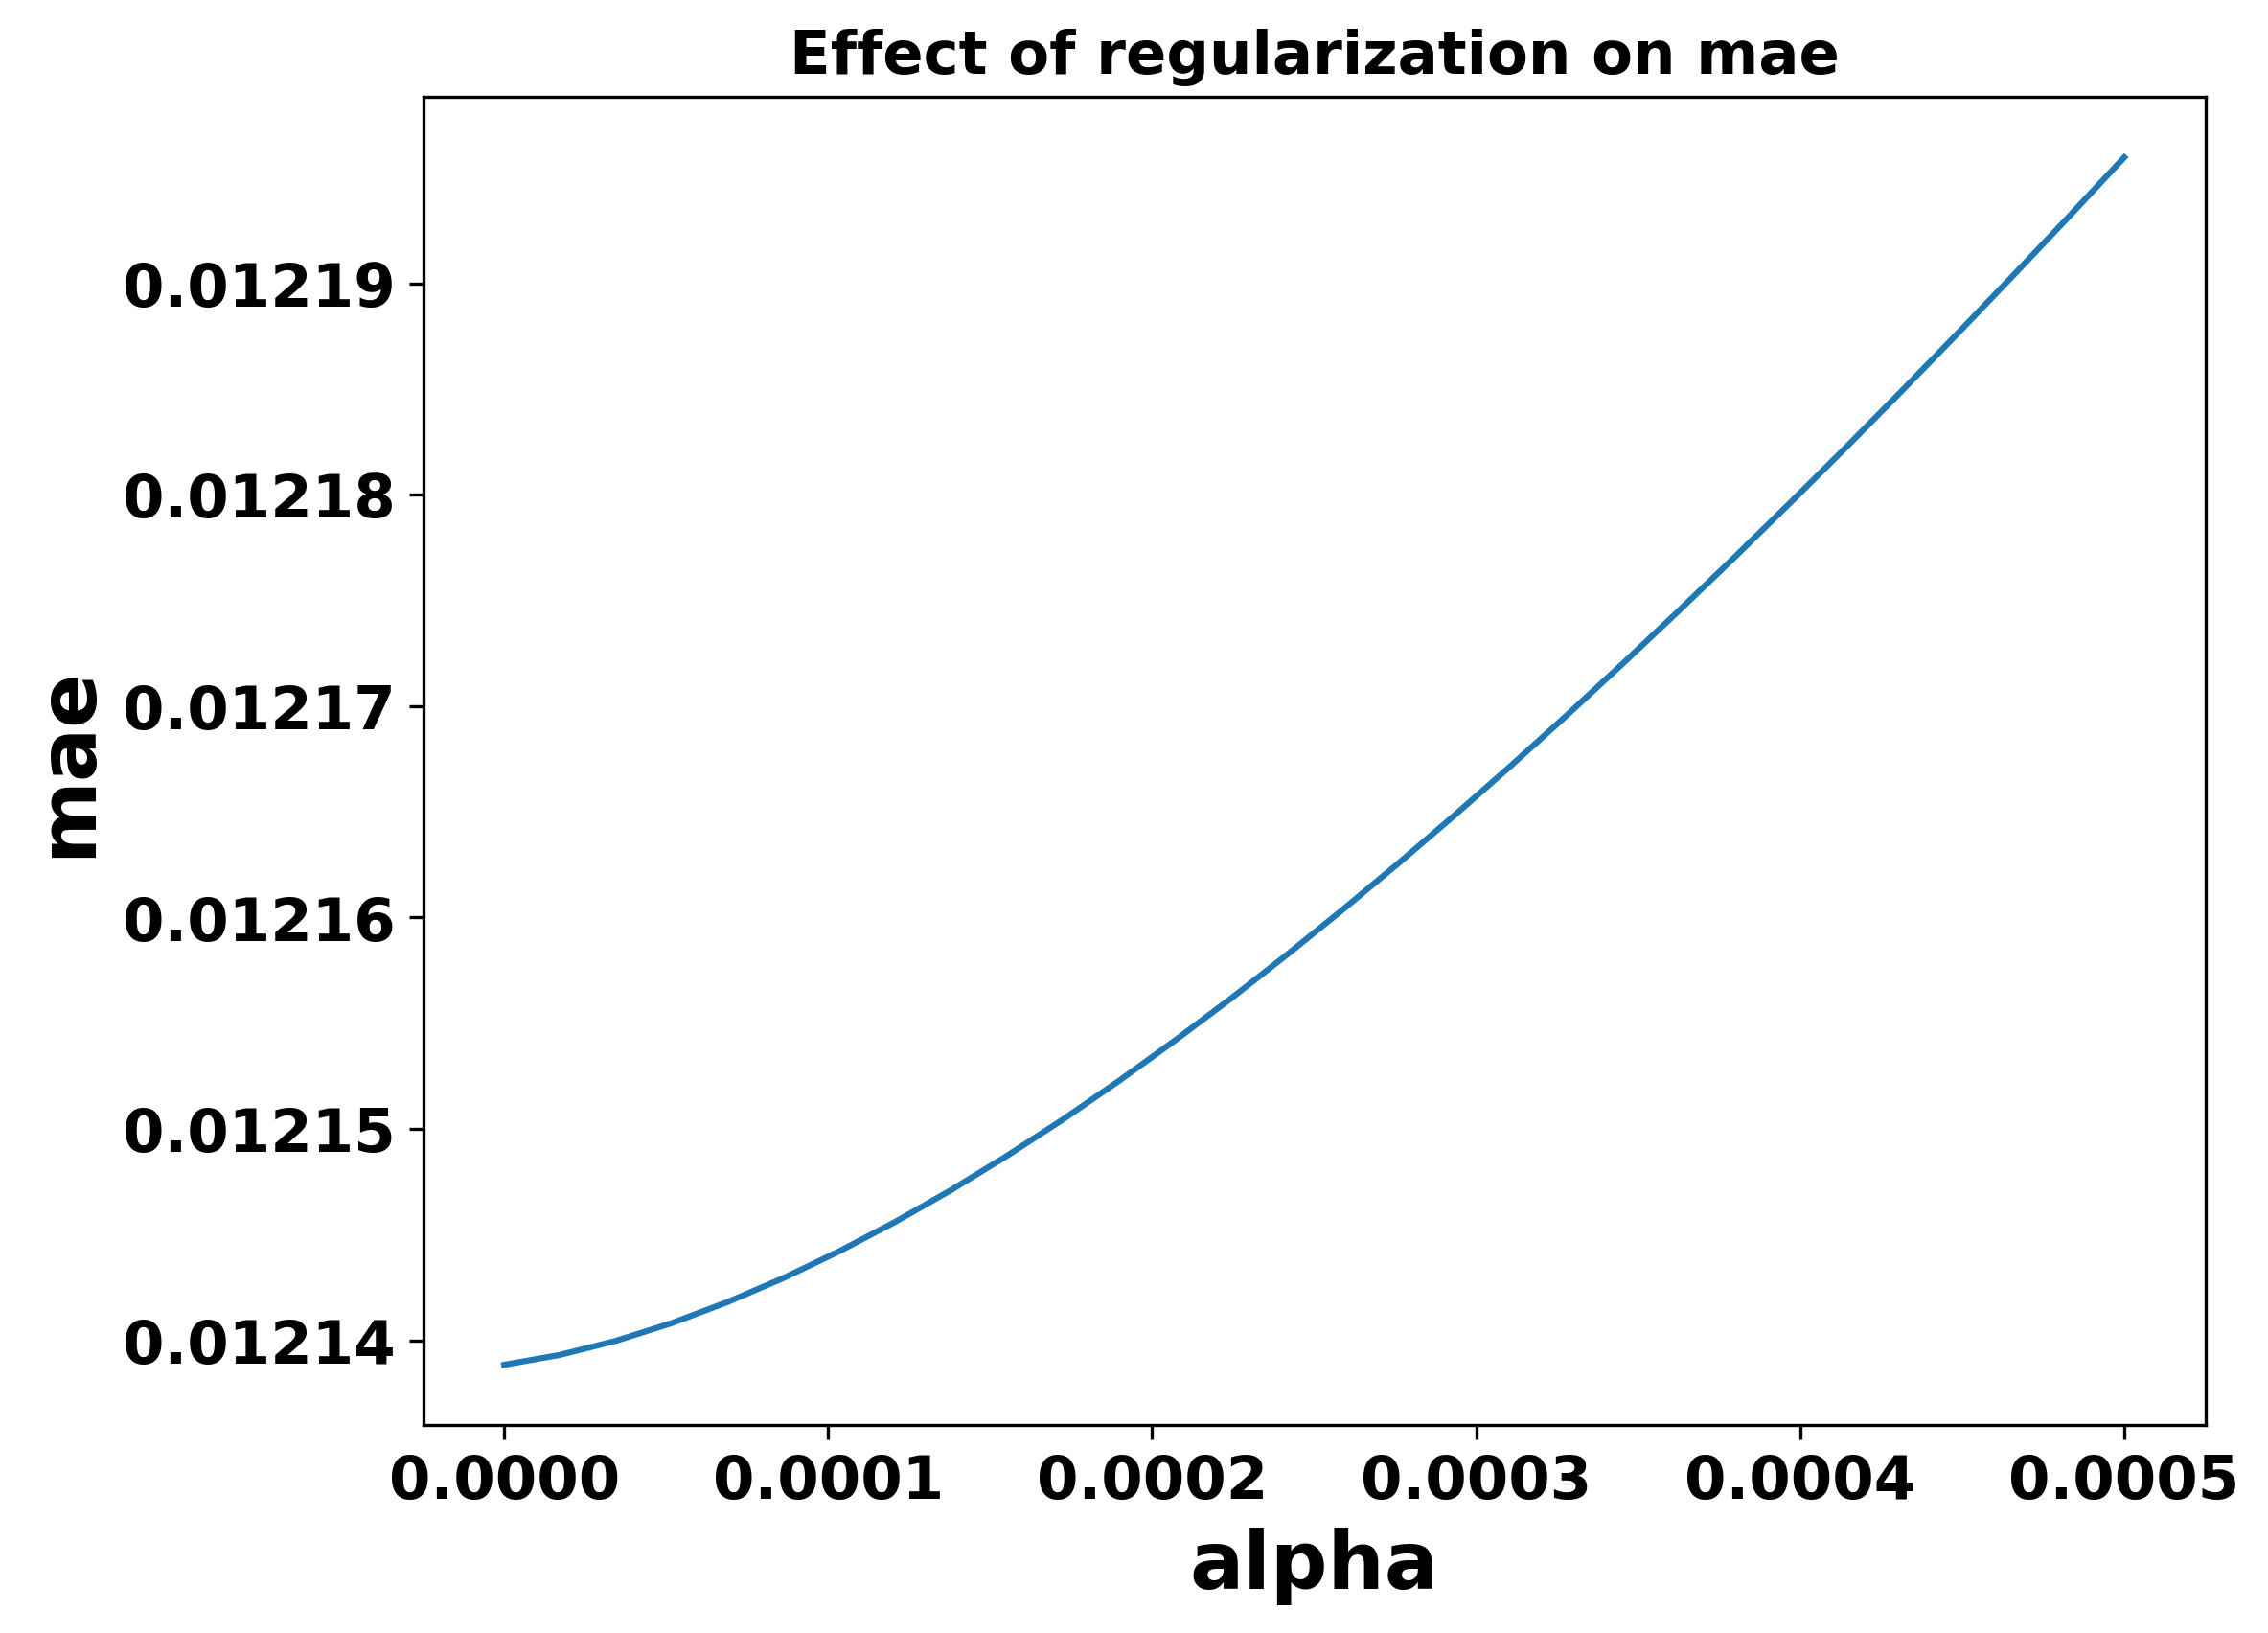

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.linspace(0, min, resolution), np.mean(mae[:,0,:, :], axis=(0, 1)))


ax.set_xlabel("alpha", fontweight="bold", fontsize=20)
ax.set_ylabel("mae", fontweight="bold", fontsize=20)
ax.set_title("Effect of regularization on mae", fontweight="bold")
ax.minorticks_off()


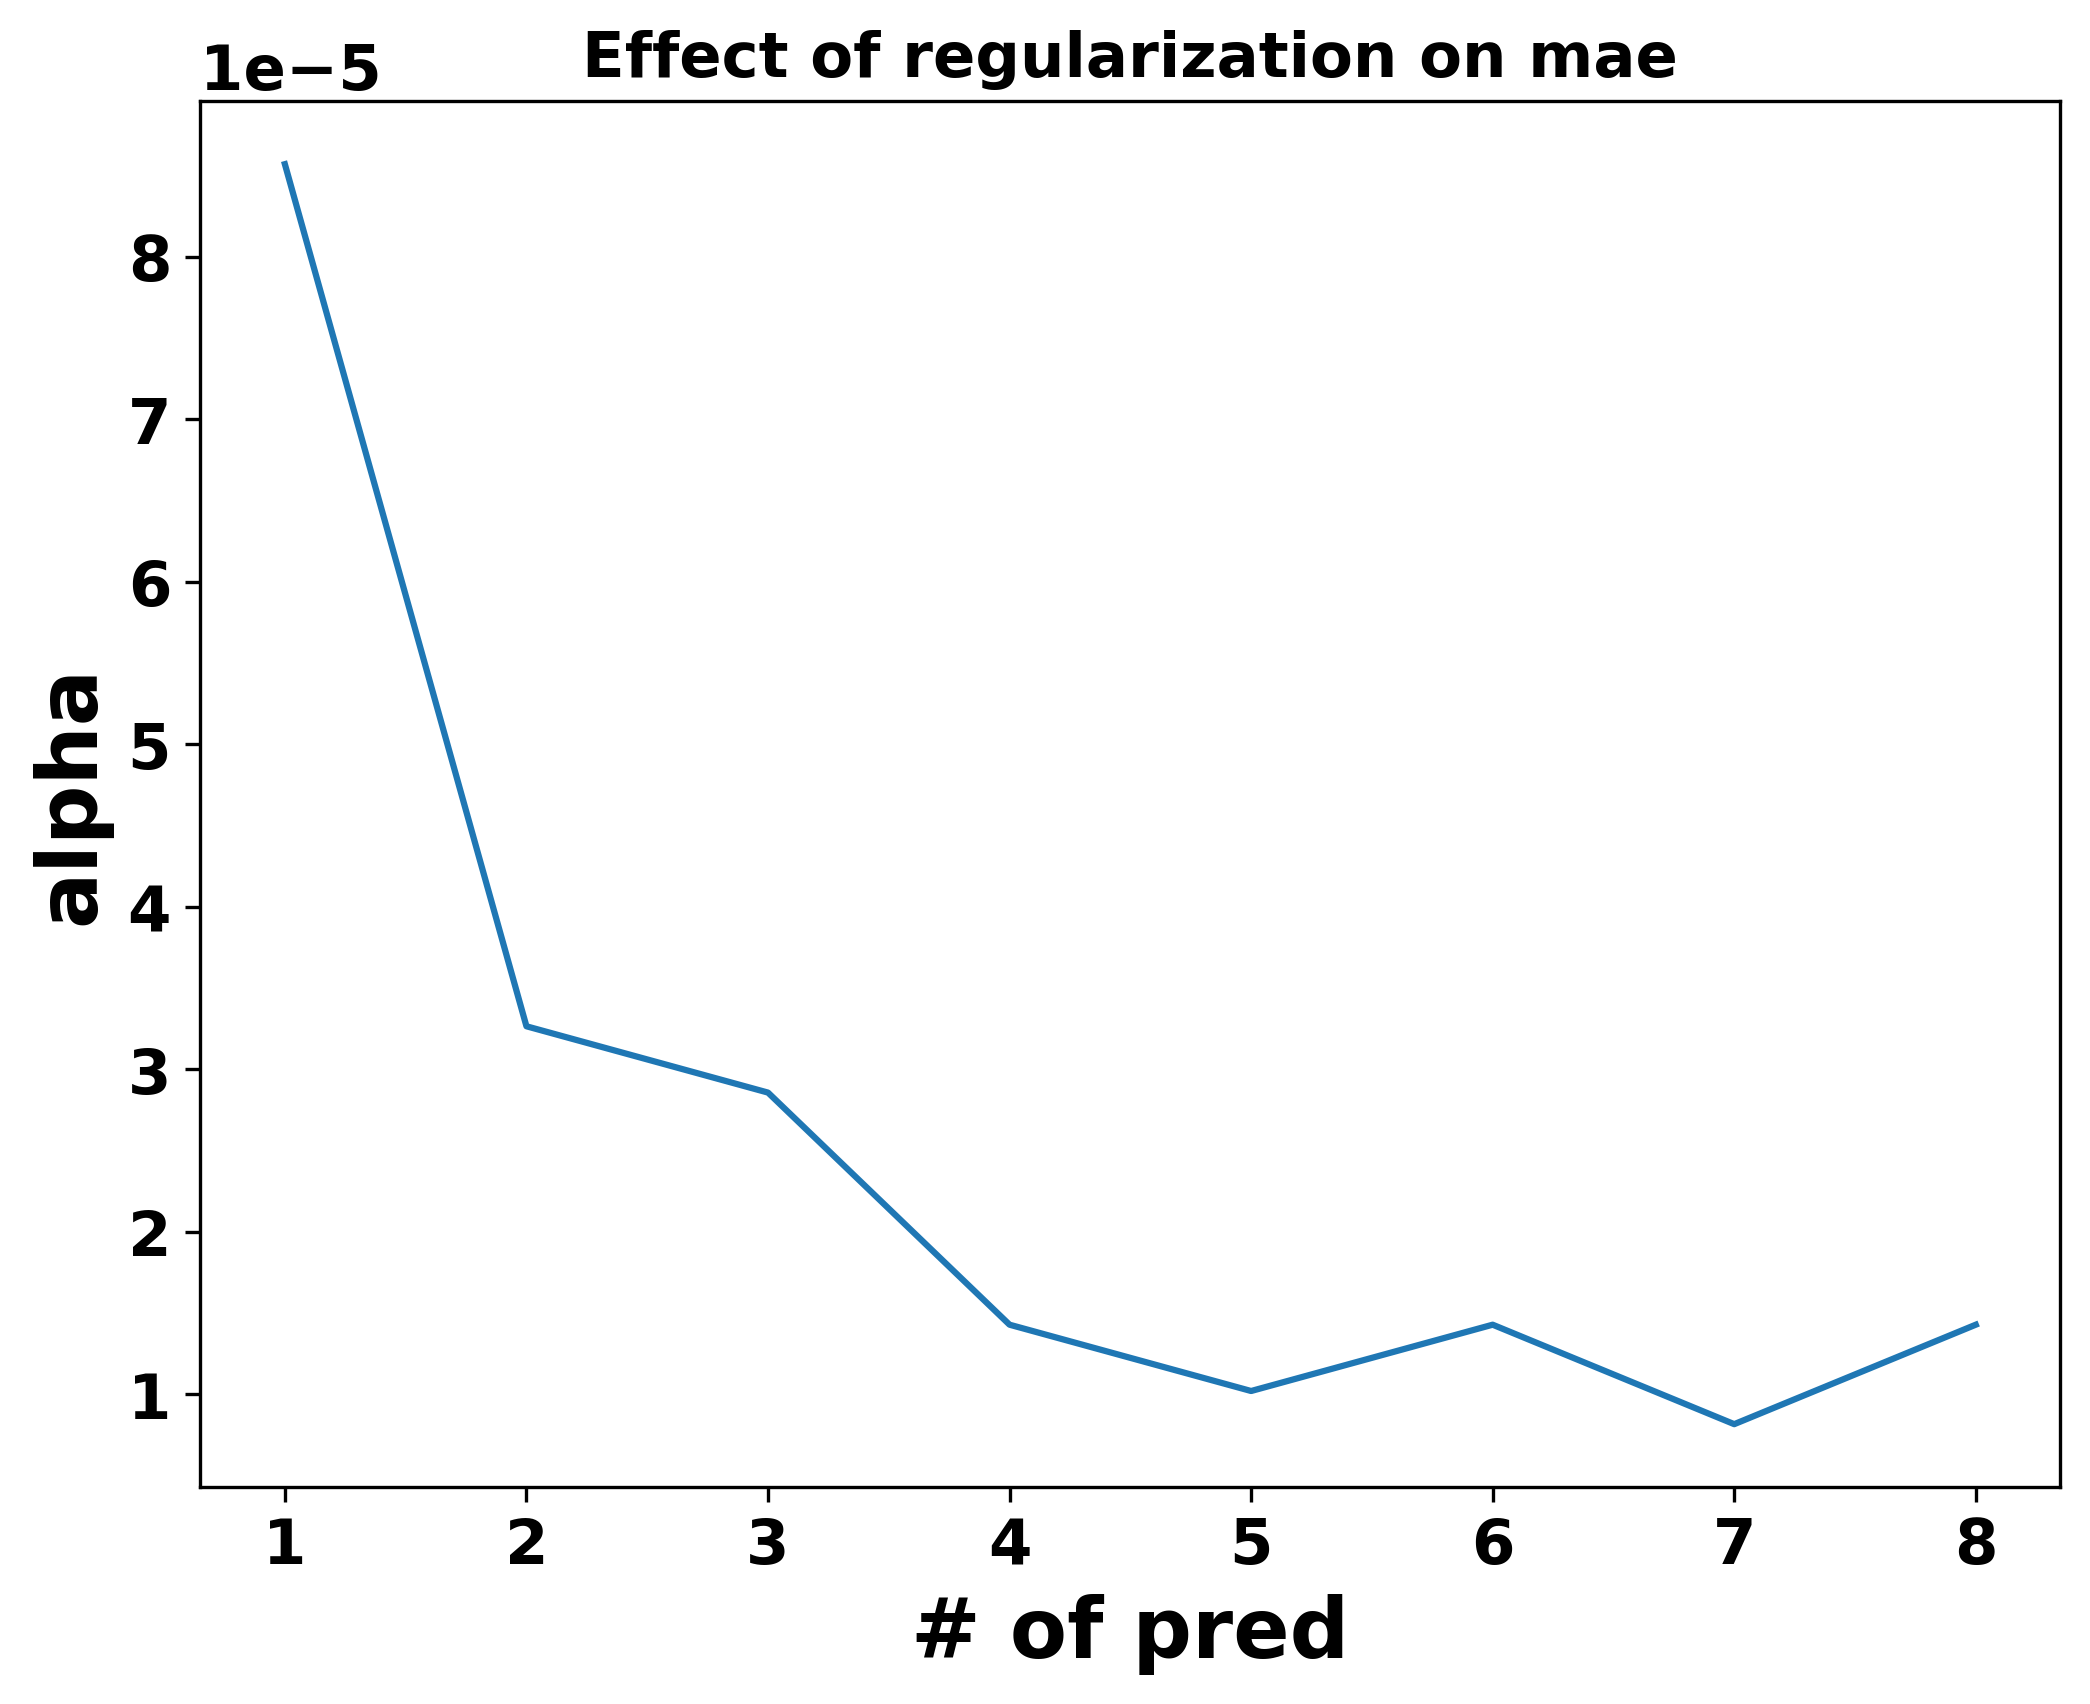

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
alpha_list = []
for i in range(8):
    index = np.where(mae[9,i,3, :]==mae[9,i,3, :].min())
    alpha_list.append(np.linspace(0, min, resolution)[index[0]])
ax.plot(np.arange(1, 9), alpha_list)


ax.set_xlabel("# of pred", fontweight="bold", fontsize=20)
ax.set_ylabel("alpha", fontweight="bold", fontsize=20)
ax.set_title("Effect of regularization on mae", fontweight="bold")
ax.minorticks_off()

Parameters to try: alpha = 3.8-05e

input = 14, max_lag = 6 

input = 9, max_lag = 6

input = 7, max_lag = 6

input = 7, max_lag = 5

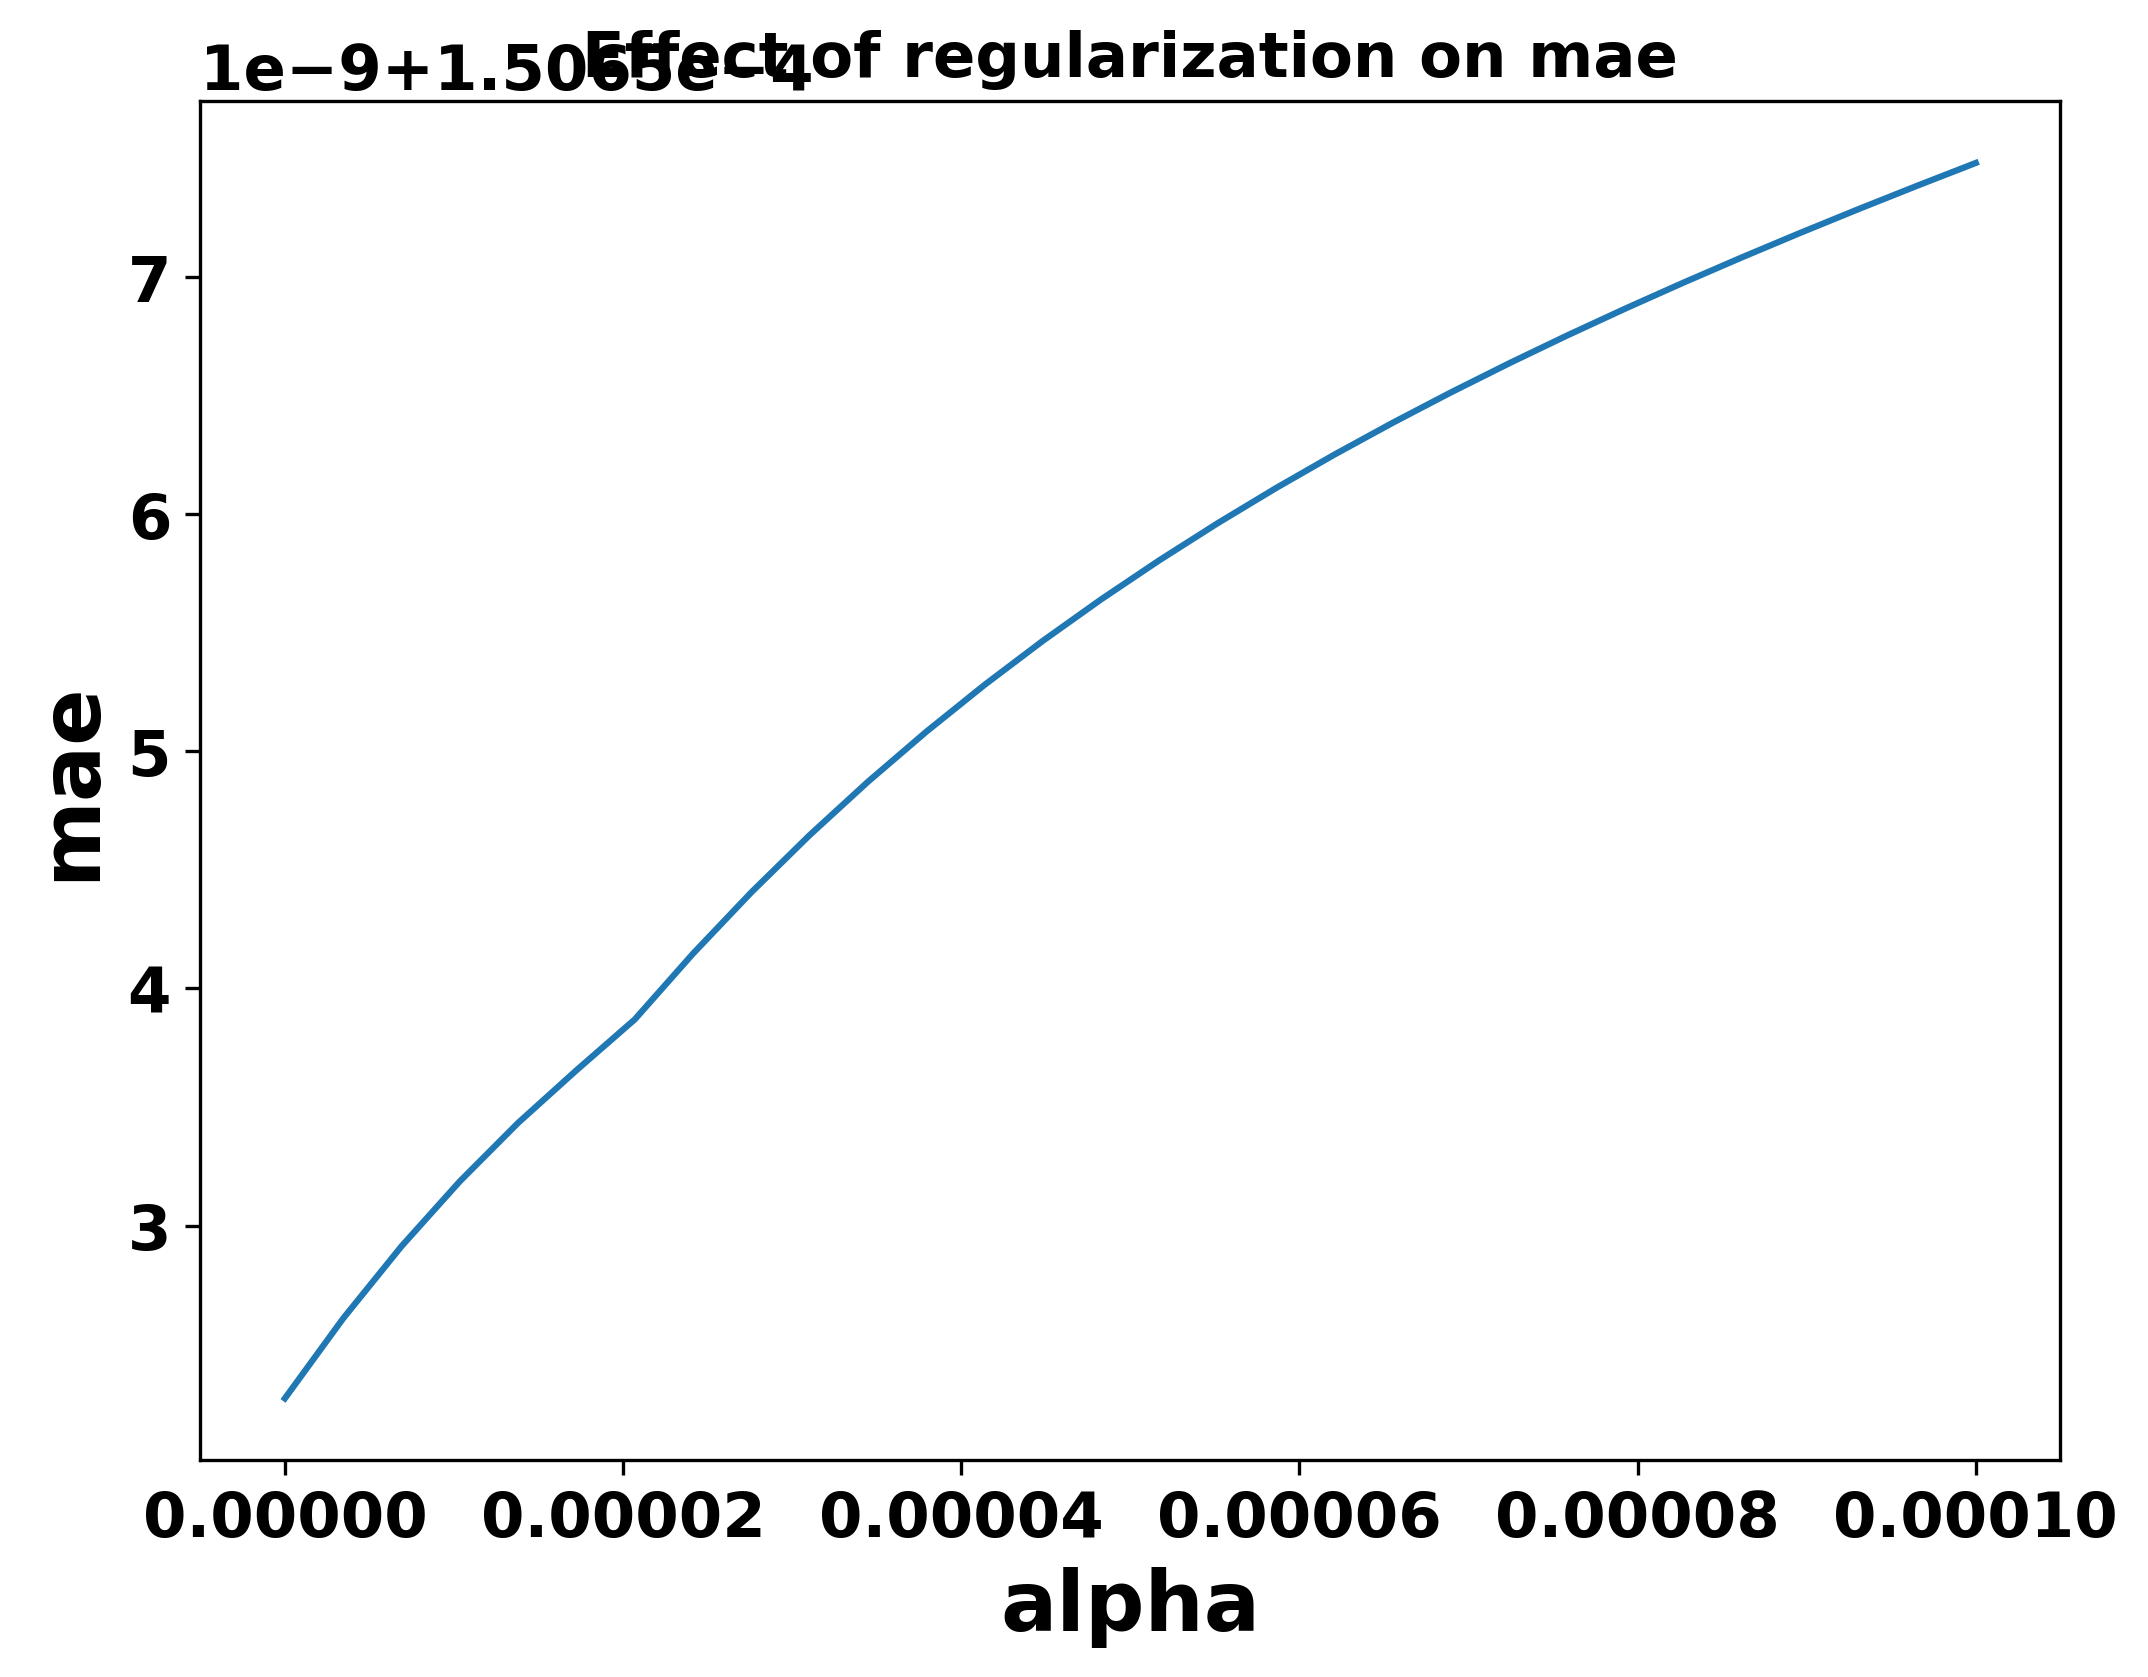

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
min = 0.0001
ax.plot(np.linspace(0, min, 30), mae[8, 0, 2, :])


ax.set_xlabel("alpha", fontweight="bold", fontsize=20)
ax.set_ylabel("mae", fontweight="bold", fontsize=20)
ax.set_title("Effect of regularization on mae", fontweight="bold")
ax.minorticks_off()


# Normal Equation
Needs a large input (50 works) and performs an order of magnitude worse than SVD

### No regularization

In [89]:
mae = np.zeros((10, 8, 6))
# Remove the range for pred, just run it once and then calculate the error for each prediction step
for i in range(10):
    print(i)
    for k in range(6):
        mol_mae = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':4000')
        #try:
        mae[i, :, k] = evaluate_model(mol=mol_mae, input=i+100, pred_step=8, method="Inverse", max_lag=k+1)
        #except:
         #   print(i+6, 8, k+1)

0
1
2
3
4
5
6
7
8
9


In [90]:
print(np.where(mae[:,0,:]==mae[:,0,:].min()))


print(mae.min())
print(mae[2:, 0, :])

(array([6], dtype=int64), array([2], dtype=int64))
0.00011595771427081794
[[1.45786142e-04 1.27377715e-04 1.30058556e-04 9.38385411e-03
  6.26371984e-02 6.97438416e-02]
 [1.32280850e-04 1.25929021e-04 1.26420426e-04 2.64698725e-02
  5.13260980e-02 2.30895149e-02]
 [1.28758520e-04 1.21530153e-04 1.25629487e-04 3.36564125e-03
  4.09774417e-02 2.98700464e-02]
 [1.54304165e-04 1.36465889e-04 1.38303836e-04 4.65137440e-03
  3.27155594e-02 3.34050563e-02]
 [1.22447229e-04 1.16528591e-04 1.15957714e-04 6.52099693e-03
  3.71253101e-02 1.26447107e-01]
 [1.34570101e-04 1.30241234e-04 1.31919721e-04 3.14366301e-03
  2.64745679e-02 8.25550400e-02]
 [1.42692371e-04 1.25129613e-04 1.28162692e-04 2.75547794e-03
  1.98737433e-02 3.30672470e-02]
 [1.41781564e-04 1.29792644e-04 1.30662450e-04 2.05748699e-03
  1.23043038e-02 2.88132841e-02]]


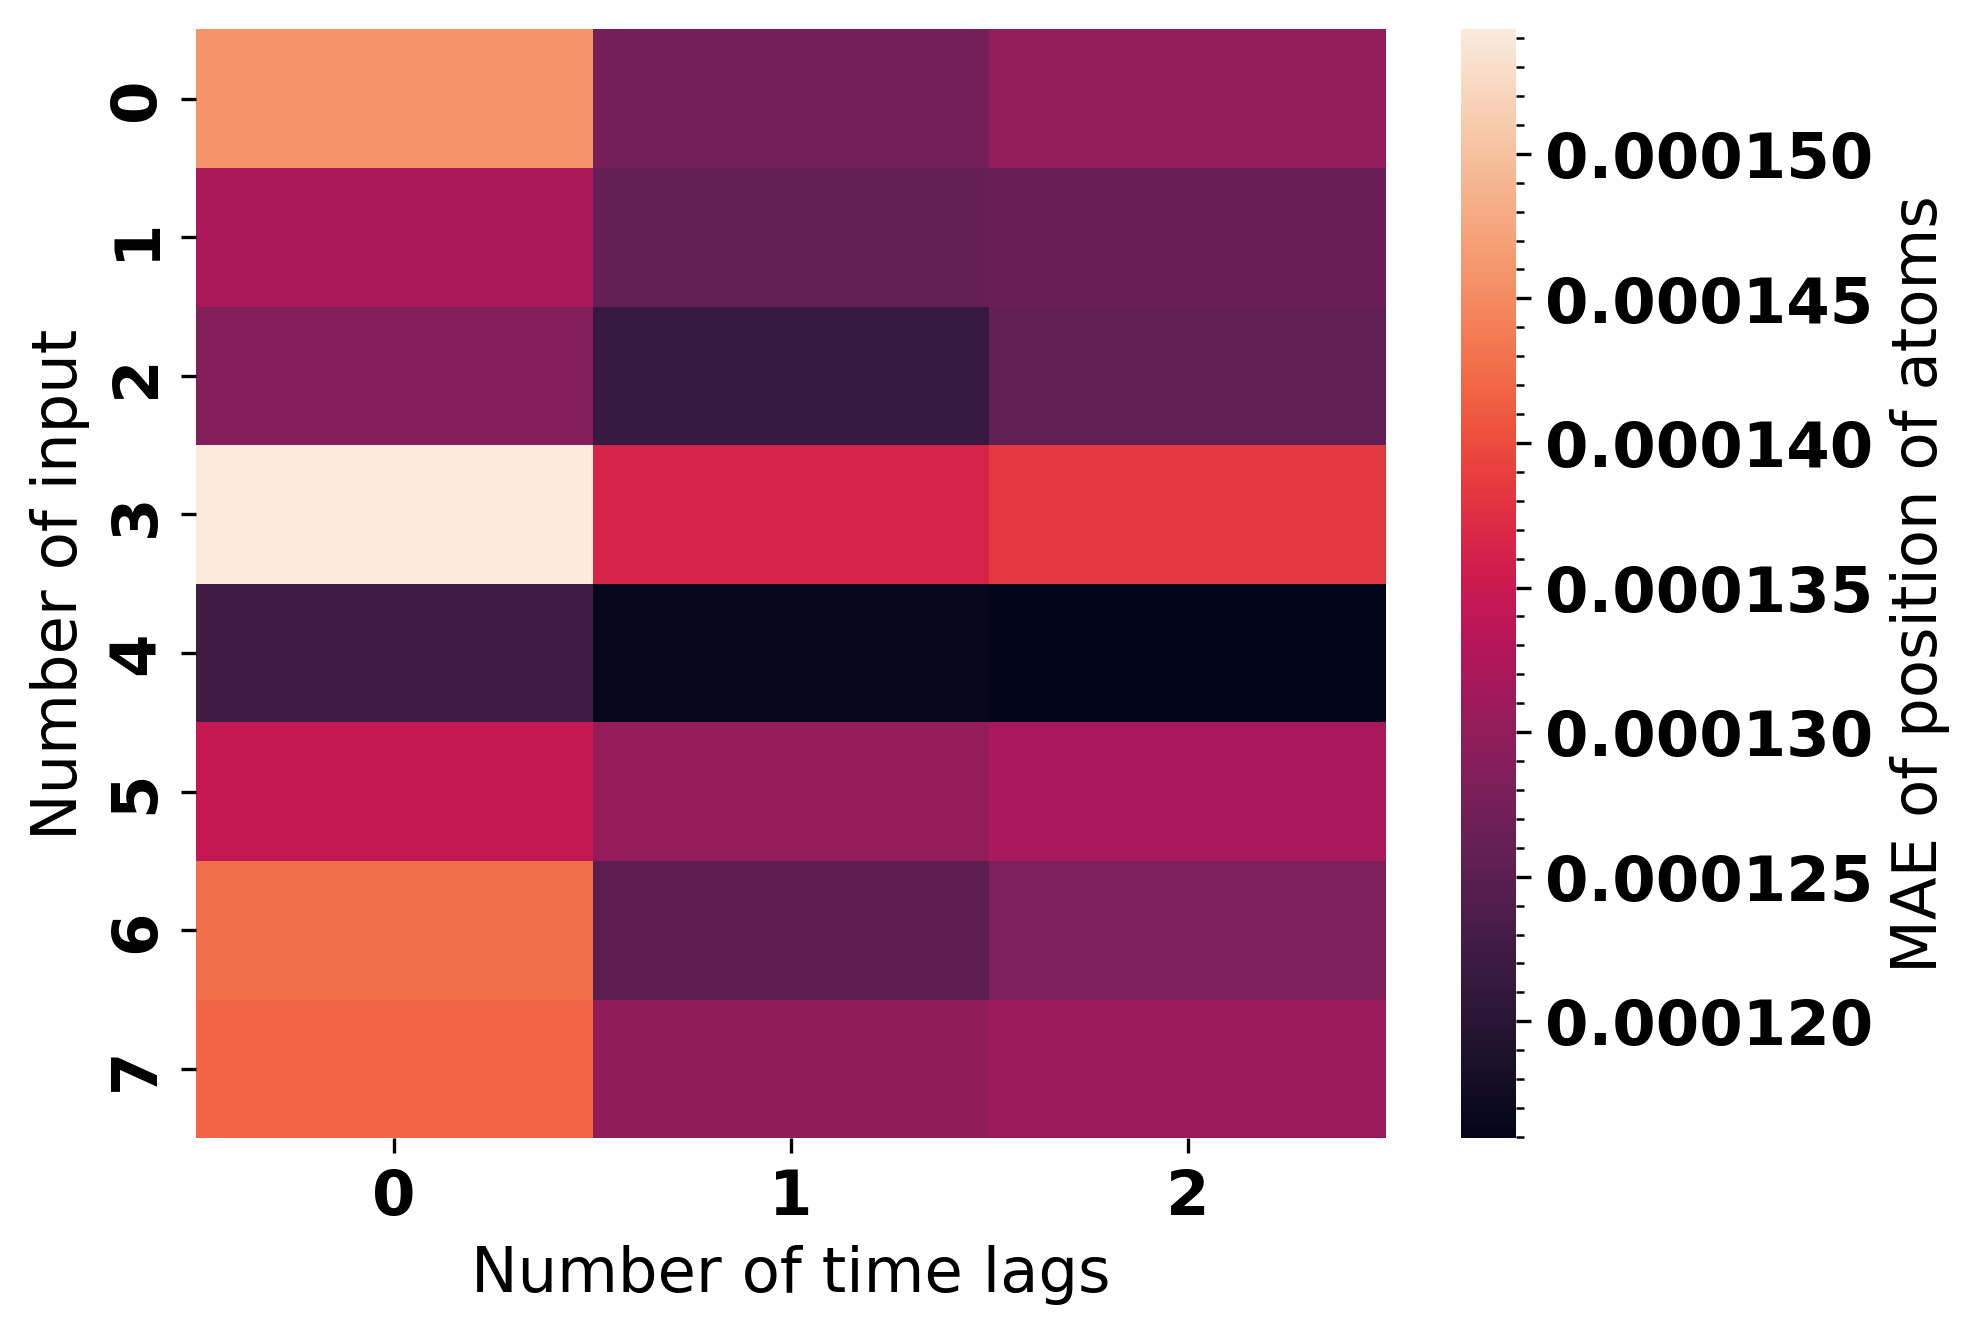

In [91]:
#ax = sns.heatmap(np.mean(mae[:,:2,:], axis=1)[2:, :], cbar_kws={'label':"MAE of position of atoms"})
ax = sns.heatmap(mae[2:,0, :3], cbar_kws={'label':"MAE of position of atoms"})
ax.set(xlabel="Number of time lags", ylabel="Number of input")
#ax.set_yticklabels(range(8, 16))
#ax.set_xticklabels(range(1, 7))

ax.minorticks_off()

### Regularization

In [95]:
mae = np.zeros((10, 8, 6, 10))
# Remove the range for pred, just run it once and then calculate the error for each prediction step
for i in range(10):
    print(i)
    for k in range(6):
        for j in range(10):
            mol_mae = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':1000')
            #try:
            mae[i, :, k, j] = evaluate_model(mol=mol_mae, input=i+50, pred_step=8, method="Inverse", max_lag=k+1, alpha=j*0.1)
            #except:
            #   print(i+6, 8, k+1)

0
1
2
3
4
5
6
7
8
9


In [96]:
print(np.where(mae[:,0,:]==mae[:,0,:].min()))


print(mae.min())
print(mae[2:, 0, :])

(array([3], dtype=int64), array([3], dtype=int64), array([9], dtype=int64))
0.0001352965939935095
[[[1.60465790e-04 1.52692518e-04 1.50556051e-04 1.49720744e-04
   1.49139507e-04 1.48616018e-04 1.48176065e-04 1.47834870e-04
   1.47569259e-04 1.47319927e-04]
  [1.69509467e-02 1.53642542e-04 1.51950239e-04 1.50701252e-04
   1.49677905e-04 1.48856730e-04 1.48310479e-04 1.47829463e-04
   1.47415124e-04 1.47036794e-04]
  [3.76617550e-02 1.54493818e-04 1.53256285e-04 1.52116583e-04
   1.51143430e-04 1.50279493e-04 1.49524904e-04 1.48845749e-04
   1.48276736e-04 1.47761796e-04]
  [9.93574788e-02 1.54869801e-04 1.53989142e-04 1.53021147e-04
   1.52121136e-04 1.51291531e-04 1.50528811e-04 1.49815971e-04
   1.49145704e-04 1.48520532e-04]
  [4.86358385e-02 1.55104804e-04 1.54382442e-04 1.53460870e-04
   1.52600465e-04 1.51836867e-04 1.51106829e-04 1.50413229e-04
   1.49762443e-04 1.49158726e-04]
  [5.80360449e-02 1.55297643e-04 1.54465863e-04 1.53569527e-04
   1.52729481e-04 1.51990512e-04 1.5135

In [ ]:
mol_mae = read("Data/Model_test/EtOH_moldyn_data.xyz", index=':1000')
print(len(evaluate_model(mol=mol_mae, input=6, pred_step=8, method="SVD", max_lag=2)))

8
